<a href="https://colab.research.google.com/github/myrronaguila/analyze_sqc/blob/main/qutip%20Bloch%20Sphere%20Animation/1Q_Gates_with_Probability_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bloch Sphere Evolution of 1Q gate Demonstration:

By Myrron Albert Callera Aguila, PhD (20231017)

In [ ]:
#Python library installed #34 seconds
!pip install qutip==4.7.3     # for quantum operations => 4.7.3
!pip install qutip-qip==0.3.0 # extension of quantum operations => 0.3.0

!pip install ghostscript==0.7 # for showing transpiler => 0.7
!pip install folium==0.2.1 #error; folium-0.14.0 org
!pip install pdflatex==0.1.3 #=> 0.1.3

#for mp4 animation
!apt install ffmpeg    # for qubit animation => 7:4.4.2-0ubuntu0.22.04.1
!apt install imagemagick # for image animation => -6.q16
!apt install pdf2svg #convert pdf2svg for circuit list =>
!sudo apt-get install texlive-latex-recommended #textlive latex => none
!sudo mv /etc/ImageMagick-6/policy.xml /etc/ImageMagick-6/policy.xml.off #needed for qip setup to work
!sudo apt install texlive-latex-extra #data analysis => none
!sudo apt install dvipng #convert qutip image to png without latex =>1.15-1.1

#for imageio method then change from gif to .mp4

!pip install Latex==0.7.0 #install latex for listing plots => 0.7.0
!pip install latextools==0.5.0 #install latextools => 0.5.0
#runtime: 2m 34s

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79793 sha256=3dd8f219a062afe1df3d6fd155bc4cceaa459baba66a25aa7ee66ef33c7e9c35
  Stored in directory: /root/.cache/pip/wheels/00/0c/07/d7792a5444d5bb074361ac27da53cee9d5cce59a07fe9da5dd
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.14.0
    Uninstalling folium-0.14.0:
      Successfully uninstalled folium-0.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.17.6 requires folium>=0.9.1, but you have folium 0.2.1 which is incompatible.
geemap 0.28

In [ ]:
#imported libraries
#computational commands for imported plots
import numpy as np
import scipy
import qutip

#showing installed components
import inspect #useful for printing python modules uploaded
import sys #for printing imported python modules and versions
#runtime = 2m 31s

# perform animation of gate rotation
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [ ]:
#imported classes from libraries
from functools import partial

#Activate 3D projection
from mpl_toolkits.mplot3d import Axes3D

# basis of setting states in Qutip, refer to https://qutip.org/docs/latest/guide/guide-basics.html
# single-qubit gate operation, refer to https://qutip.org/docs/latest/guide/qip/qip-basics.html
from qutip import basis, Qobj, sigmax, sigmay, sigmaz, tensor, expect

from IPython.display import Image # https://github.com/qutip/qutip-qip/issues/64

#from qutip.qip.circuit import QubitCircuit, Gate
from qutip_qip.circuit import QubitCircuit
#add rotation operators for phi and theta - useful for making trajectories
#https://qutip-qip.readthedocs.io/en/stable/apidoc/qutip_qip.operations.html#qutip_qip.operations.rotation
from qutip_qip.operations import RX, RY, RZ, Gate
from qutip.qip import hadamard_transform #Hadamard evolution

## Important Library

In [ ]:
# no change from 20230928
def extract_state_info_qt(init_state):
  """
  20230926 Data analysis
  Extract appropriate qutip parameters using qt.expect
  # no good analysis if theta and phi have flawed database
  Get coordinates from state. To simplify, we get the theta and phi after
  state readout.
  Input
    init_state: Qobj
      state preparation
    norm: string
      norm='Y' => normalized to unit vector
      norm='N' => get raw state
  Output:
    dict_info: dictionary
      dict_info[0]: list of floats in coordinates
        [u, v, w]
      dict_info[1]: list of floats in radians
        [theta, phi]
      dict_info[2]: list of floats in fractions
        [alpha**2, beta**2]
  """
  #assess whether normalization is important
  alpha, beta = init_state.full().flatten()
  if (np.abs((alpha*np.conj(alpha))) + np.abs((beta*np.conj(beta)))) > 1:
    init_state = init_state.unit()
  else:
    init_state = init_state

  u, v, w = expect([sigmax(), sigmay(), sigmaz()], init_state) #assuming pure-state

  #obtain state angle phi and theta, solved
  theta = np.arccos(w) #rotation between |0> (theta/2=0) to |1> (theta/2=180)
  phi = np.angle(u + 1j*v) #rotation from +x to +y to -x to -y to +x
  if phi < 0:
    #phi correction
    phi += 2*np.pi

  #define coefficient of the state vectors according to psi
  alpha = np.cos(theta/2)
  beta = np.sin(theta/2)*np.exp(1j*phi)

  #data analysis of probabilities
  alpha_sqr = np.abs(alpha*np.conj(alpha))
  beta_sqr = np.abs(beta*np.conj(beta))

  dict_info = {'prob': np.asarray([alpha_sqr, beta_sqr]),
               'coord': np.asarray([u, v, w]),
               'theta_phi': np.asarray([theta, phi]),
               'alpha_beta': np.asarray([alpha, beta])}
  return dict_info

Rotation Gate Animation

In [ ]:
#finalized rot r-angle in degrees
def rot_R(init_list, angle, pts=3):
  """
  Basic rotation gates.

  input:
    init_list: list of objects
      init_list[0] = initial state in Qobj
      init_list[1] = target qubit [default=0] in integer
      init_list[2] = string N -> ['X', 'Y', 'Z', 'H'] rotation on the n-axis
    angle: float
      refers to rotation around a certain axis by degrees [for clarity]. Note
      that the value here is not the same as the theta and phi angles in the
      bloch statevector
    pts: float
      Number of Rotations in the Z-axis, min number of points is 3 just to
      make an arc between two lines for drawing expected trajectories

  output:
    list of unitary matrix, the angle is independent of the qubit state
  """
  # unpack variables
  init_state = init_list[0] #initial state of evolution
  target = init_list[1] #qubit target, initial is 0 for single qubit
  str_rot = init_list[2] #rotation around N-axis

  #check state angle coordinates for Hadamard Gate Transform.
  dict_state = extract_state_info_qt(init_state=init_state)
  theta = dict_state['theta_phi'][0]
  phi = dict_state['theta_phi'][1]
  #print('theta = {:.3f} deg; phi = {:.3f} deg'.format(np.degrees(theta), np.degrees(phi)))
  #RX, RY, and RZ are multidimentional. However, we confine to single-qubit only
  # Set rotations around needed axes and create a list of rotation matrices using qip-operations contrl
  rot_arr = np.linspace(0, angle, pts) # 0 is initial state, angle for variable angles in degrees
  if str_rot == 'X':
    rot_arr = np.linspace(0, 180, pts)
    obj_arr = [RX(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'Y':
    rot_arr = np.linspace(0, 180, pts)
    obj_arr = [RY(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'Z':
    rot_arr = np.linspace(0, 180, pts)
    obj_arr = [RZ(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'H':
    #https://physics.stackexchange.com/questions/313959/visual-interpretation-on-the-bloch-sphere-when-hadamard-gate-is-applied-twice
    #the gate - based on hamiltonian transformation
    hadamard = hadamard_transform()
    # the hamilton operator describing the evolution during the hadamard gate
    hamilton = Qobj(scipy.linalg.logm(hadamard.data.todense()), dims=hadamard.dims) / np.pi * 1.j
    # describing the gate as time evolution
    def gate(t):
      return (-2*np.pi*1.j*hamilton*t).expm()
    obj_arr = [gate(t) for t in np.linspace(0, 0.5, pts)]
  elif str_rot == 'I':
    #useful for two-qubit representation of CNOT telling idle qubit times
    obj_arr = [Qobj([[1, 0], [0, 1]]) for i in range(pts)]
  elif str_rot == 'S':
    #S or Z90 gate.
    rot_arr = np.linspace(0, 90, pts)
    obj_arr = [RZ(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'T':
    #T or Z45 gate
    rot_arr = np.linspace(0, 45, pts)
    obj_arr = [RZ(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'RX':
    obj_arr = [RX(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'RY':
    obj_arr = [RY(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'RZ':
    obj_arr = [RZ(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  #output evolving states
  state_arr = [obj_arr[i]*init_state for i in range(pts)] #a list of qobj
  return obj_arr, state_arr

Draw gate arcs to visualize qubit trajectory for every qubit gates

In [ ]:
#additional programs for determining arcs and states for drawing
def gate_arcs_all(list_states):
  #provides list of states for arc formation
  """
  extract list of coordinates from given states with regard to expected trajectories per gate
  #flaw - useful for simple gates but not useful for complicated states

  Input:
    list_state: list of states per gate
  Output:
    list of list of vectors in [[u1,v1,w1], [u2,v2,w2], [u3,v3,w3]]
  """
  n = len(list_states)

  #get x,y,z list of all states
  arc_coords = [extract_state_info_qt(list_states[i])['coord'] for i in range(n)]
  return arc_coords

#convert cm to inches.
def cm_to_inch(x):
  return x/2.54

Testing 1Q animation evolution using configuration files

In [ ]:
#test init states
dict_psi = {'test_0': basis(2,0),
            'test_1': basis(2,1),
            'test_+': (1/np.sqrt(2))*(basis(2,0) + basis(2,1)),
            'test_-': (1/np.sqrt(2))*(basis(2,0) - basis(2,1)),
            'test_+j': (1/np.sqrt(2))*(basis(2,0) + 1j*basis(2,1)),
            'test_-j': (1/np.sqrt(2))*(basis(2,0) - 1j*basis(2,1))}

# Task 1: Plot |1> Probabilities

Animate Bloch Sphere Probability |1> through operations

In [ ]:
# configuration file includes gate sequences
test = 'test_0'
psi_test1 = dict_psi[test]
# test for X plot
pts = 9 #must be odd
gate_list = ['X', 'X', 'X', 'X'] # 4 gates
purpose = '4X_'+str(int(pts))+'pts'
gate_angle = np.asarray([180, 180, 180, 180])

#Add I gate
def user_gate_I():
     # Identity Gate
     mat = np.array([[1.,   0],
                     [0., 1.]])
     return Qobj(mat, dims=[[2], [2]])

#Plot circuits and get list of states
qc = QubitCircuit(N=1, num_cbits=1)
qc.user_gates = {"I": user_gate_I} #add I-gate

# add control line that applies the gates
qc.add_state(state='0', targets=[0], state_type='input') #qubit operated upon
qc.add_state(state='c0', targets=[1], state_type='input') #classical register for measurement and control

# Automate gate list. Is it necessary to put classical controls?
n = len(gate_list)

#use list comprehension for this work - works for 1Q
#classical controls are setups that helps control the gate or do not help control
#the gate. What CZ does not help is the analysis

#circuit drawing is dependent on the propagators of the circuit
[qc.add_gate(gate_list[i], targets=0, classical_controls=[0]) if gate_list[i][0] != 'R'
else qc.add_gate(gate_list[i], targets=0, classical_controls=[0],
                 arg_value=np.radians(gate_angle[i]),
                 arg_label=r'{:1d}^o'.format(gate_angle[i])) for i in range(n)]

# plot circuits
qc.draw(file_type='png', file_name='circuit_1Q_'+purpose)

#relabel gates for tracking in animation
gate_names = [gate_list[i] if (gate_list[i][0] != 'R')
              else (gate_list[i] + '(' + str(gate_angle[i]) + r'$^{o}$' + ')')
              for i in range(n)]

#use propagators - propagators work only for 1Q
props = qc.propagators()

# Advantages: no need for making a unitary matrix
#set final and initial state of access
gate_fin_arr = [psi_test1 for i in range(n)]
for i in range(n):
   if i == 0:
     gate_fin_arr[i] = Qobj(props[i]*gate_fin_arr[i])
   else:
     gate_fin_arr[i] = Qobj(props[i]*gate_fin_arr[i-1])
  #this can be made in list-comprehension for speed.
  #advantage

gate_start_arr = [psi_test1] + gate_fin_arr[:int(n-1)]

# for debug purposes
debug = 'N'
if debug == 'Y':
  #Get Initial State
  print('State after Operation:')
  print(gate_fin_arr)
  print('\n')
  #get initial state before gate operation for iterative generation of animation
  print('State before Operation')
  print(gate_start_arr)

/usr/local/lib/python3.10/dist-packages/qutip_qip/circuit/circuit_latex.py:95: UserWarning: Could not locate system 'pdfcrop': image output may have additional margins.
  warnings.warn(


In [ ]:
#make sequential animation to highlight trajectories
#We make a list of 1D lists of animated Qobj states for a single qubit
state_anim_list = [rot_R(init_list=[gate_start_arr[i], 0, gate_list[i]],
                         angle=gate_angle[i], pts=pts)[1] for i in range(n)]
print('\n')
print('Number of gates: {:1d}'.format(len(state_anim_list)))
print('Number of animation per gate : {:1d}'.format(len(state_anim_list[0])))

def flatten_comprehension(matrix):
  #Try flatten gates for drawing arcs per gate
  #https://realpython.com/python-flatten-list/
  return [item for row in matrix for item in row]

state_arr = flatten_comprehension(state_anim_list)
print('\n')
print('Number of animation per list : {:1d}'.format(len(state_arr)))



Number of gates: 4
Number of animation per gate : 9


Number of animation per list : 36


Grab |1> probabilities for simulation of Rabi Oscillations.

In [ ]:
#practice getting probability of |1> state
prob_1_state_arr = np.array([extract_state_info_qt(state_arr[i])['prob'][1] for i in range(len(state_arr))])
print(prob_1_state_arr[2])

#the extraction works. #real state problematic but the state works

0.14644660940672624


Perform state animation with frame of probabilities

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

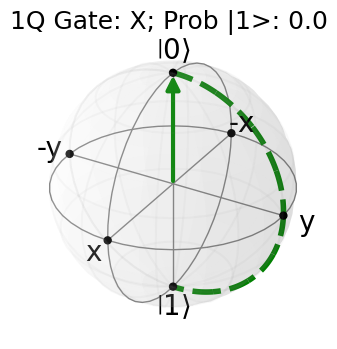

In [ ]:
#start with 1Q #20231017 - this plot is to scale with number of bloch sphere

wfig = 8.6
fig = plt.figure(constrained_layout=True, figsize = (1.5*cm_to_inch(8.6),
                                                    cm_to_inch(8.6)))
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig, hspace =0.05,
                                 wspace=0.05)

ax0 = fig.add_subplot(spec[0, 0], projection='3d')

#set initial config to bloch spheres with corresponding axes labels
#i.e. b0 = qutip.Bloch(axes=ax0), b1=qutip.Bloch(axes=ax1) ...
b0 = qutip.Bloch(axes=ax0)

#assuming state_arr is obtained from previous config file
#make a list of bloch spheres, list of animation lists and arrays of states per qubit
#we add color vector for distinction
bs_lst_1Q = [b0]
arr_lst_1Q = [state_arr]
arcs_lst_1Q = [state_anim_list]
q_cols_1Q = ['g']
zlabel_1Q = [[r'$\left|0\right>$', r'$\left|1\right>$']]
zlabel_1Q = [[]]
glabel_1Q = [[ax0, gate_names]]

#print(glabel_1Q)

def initiate_bloch_qn_with_arc(bs, list_states=[], qcol='g', zlabel=[]):
    """
    Initialize plot of bloch sphere. Must be dedicated to only one sphere of
    interest. The good thing is that one can externally assign bloch spheres
    for modification.

    In the future, it would be nice to extend labeling Z-axes for information.

    Based on old script

    Parameters
    ----------
    bs : Bloch
      qutip bloch sphere
    list_states: list of Qobj
      state vectors giving hints for arc trajectory
    *kwargs: additional keynote arguments


    Returns
    -------
    None.

    """
    # Highlight nodes on diagram
    # |0>, -y, +x, +y
    # D:\Postgrad Projects\Qiskit_Textbook\bloch sphere plotting\qutip q2_sq cz_operate\Qutip q1=0.py
    xp = np.asarray([0, 0, 1, 0, 0, -1])
    yp = np.asarray([0, -1, 0, 1, 0, 0])
    zp = np.asarray([1, 0, 0, 0, -1, 0])
    pnts = [xp, yp, zp]
    bs.add_points(pnts)
    #check for same states for arc

    #draw arc based on states
    if list_states == []:
      #no need for drawing arcs if no arcs are intended to be drawn
      #useful for
      pass
    else:
      list_coords = gate_arcs_all(list_states) #shows 3 points
      f = len(list_states)
      m = int((f-1)/2) #mid point
      if ((round(list_coords[0][0],6) == round(list_coords[-1][0],6))
      & (round(list_coords[0][1],6) == round(list_coords[-1][1],6))
      & (round(list_coords[0][-1],6) == round(list_coords[-1][-1],6))):
        # make a pass if a coordinate arr[0][x,y,z] and arr[-1][x,y,z] of an arc has the same point
        # round is added to remove rounding errors
        pass
      else:
        #draw all arcs #Optimal Hadamard Trajectories are hard from transpiler
        [bs.add_arc(start=list_coords[i], end=list_coords[i+1], fmt=qcol,
                          ls='dashed', lw=4) for i in range(f-1)]

    # Format Bloch Sphere first
    bs.vector_color = [qcol, qcol, qcol, qcol]
    bs.frame_alpha = 0.05
    bs.point_color = ['k', 'k', 'k', 'k', '#CC6600']
    bs.point_marker = ['o', 'o', 'o', 'o']
    bs.frame_num = 12
    bs.sphere_alpha = 0.1
    bs.xlabel = ['x', '-x']
    bs.ylabel = ['y', '-y']
    bs.sphere_color = 'white'
    if zlabel == []:
      bs.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
    else:
      bs.zlabel = zlabel

def b_plot(i, j, bs, b_states, b_state_arcs, qcol, zlabel):
  """
  methood to scale up bs config.
  scale b sphere according to number of bloch spheres
  i - frames in int
  j - number of batches of frames in int
  bs - qutip bloch sphere
  b_states - list of states evolved by i
  b_state_arcs - list of state_arcs evolved by j
  qcol - color of vectors
  zlabel - assignment of states
  """
  bs.clear()
  initiate_bloch_qn_with_arc(bs, b_state_arcs[j], qcol, zlabel)
  bs.add_states([b_states[i]])
  bs.show()

def animate_add_vec(i, bs_lst, arr_lst, arcs_lst, qcols, zlabels, gate_labels):
  """
  animate bloch sphere entertaining configs of bloch plots.
  for every bloch sphere, there returns a corresponding axes
  i = frames
  bs_list is the bloch spheres of concern
  arr_lst is a list of 1D states all qubit vector works,
  arcs_lst is a list of arcs used for qubit gates
  qcols are list of colors of each qubit states
  z-labels are lists of states needed for operation. Default is [[], []]
  gate_labels are list of [axes, gate_labels] according to the 1Q list
  """
  #assign j for number of points per movie

  pts = len(arcs_lst[0][0]) #pts per gate
  j = int(i/(pts))
  j_max = int(len(arr_lst[0])/pts)
  print(j)
  ax_dumb = []
  for m in range(len(bs_lst)):
    #m = 1 for this list
    b_plot(i, j, bs_lst[m], arr_lst[m], arcs_lst[m], qcols[m], zlabels[m])
    # annotate gate on title. one can do arrays of labels. However, I prefer
    # distinct labels as to not output a list but more of tuples.
    ax = gate_labels[m][0]
    ax.set_title('1Q Gate: ' + gate_labels[m][1][j] + '; Prob |1>: '
                 + str(round(prob_1_state_arr[i], 3)), fontsize=18)
    ax_dumb.append(ax)
  return ax_dumb

def init(bs_lst, qcols, gate_labels):
    ax_dumb = []
    for m in range(len(bs_lst)):
      bs_lst[m].vector_color = [qcols[m]]
      #https://stackoverflow.com/questions/75492605/animate-labels-using-funcanimation-in-matplotlib
      ax = gate_labels[m][0]
      ax_dumb.append(ax)
    return ax_dumb

# inquiry with the working of the code
# does the init() function acts as precursor. Also, how do we scale the bloch
# sphere to 5Q and 9Q in sequence
# init bloch sphere states must be embedded in place.

#for scalabe lsts of states, update bs_list according to the list of operations
#and use partial
#https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html

#2023 tuple animation
#in func animation, outputting a tuple is okay for animation

ani = animation.FuncAnimation(fig, partial(animate_add_vec, bs_lst=bs_lst_1Q,
 arr_lst=arr_lst_1Q,
 arcs_lst=arcs_lst_1Q,
 qcols=q_cols_1Q,
                                           zlabels=zlabel_1Q,
                                           gate_labels=glabel_1Q),
                              np.arange(len(state_arr)),
                              init_func = partial(init, bs_lst_1Q, q_cols_1Q,
                                                  glabel_1Q),
                              repeat=False)
fname = 'b_sphere_'+'1Q_'+ purpose + '_' + test+'.mp4' #with trajectory
ani.save(fname, fps=10)

#time = 12s
#this method proves we can plot qubit trajectories side by side

Perform state animation with synchronized plot of x-vs-yplot.

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

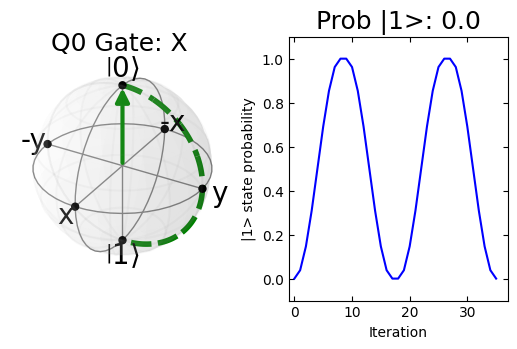

In [ ]:
#scaling to 1Q with xy plot  #20230928 - method

wfig = 8.6
fig = plt.figure(constrained_layout=True, figsize = (1.5*cm_to_inch(8.6),
                                                    1*cm_to_inch(8.6)))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, hspace =0.05,
                                 wspace=0.05)

ax0 = fig.add_subplot(spec[0, 0], projection='3d') #bloch sphere
ax1 = fig.add_subplot(spec[0, 1]) #probability of oscillation

#set initial config to bloch spheres with corresponding axes labels
#i.e. b0 = qutip.Bloch(axes=ax0), b1=qutip.Bloch(axes=ax1) ...
b0 = qutip.Bloch(axes=ax0)

# assuming state_arr is obtained from previous config file
# make a list of bloch spheres, list of animation lists and arrays of states per
# qubit
# we add color vector for distinction
bs_lst_1Q_plot = [b0]
arr_lst_1Q_plot = [state_arr]
arcs_lst_1Q_plot = [state_anim_list]
q_cols_1Q_plot= ['g']
zlabel_1Q_plot = [[r'$\left|0\right>$', r'$\left|1\right>$']]
glabel_1Q_plot = [gate_names] #simpler but requires non-automated axes

# set plot for initial qubit probability for 4 X gates
iter = np.linspace(0, len(state_arr) - 1, len(state_arr))
#scat = ax1.scatter(0, prob_1_state_arr[0], c="b", s=5) #plot scatter data
line = ax1.plot(0, prob_1_state_arr[0], 'b-')[0] #plot line data
ax1.set(xlim=[-1, len(iter)+1], ylim=[-0.1, 1.1], xlabel='Iteration', ylabel='|1> state probability')
ax1.tick_params(direction='in', right=True, top=True)

def initiate_bloch_qn_with_arc(bs, list_states=[], qcol='g', zlabel=[]):
    """
    Initialize plot of bloch sphere. Must be dedicated to only one sphere of
    interest. The good thing is that one can externally assign bloch spheres
    for modification.

    In the future, it would be nice to extend labeling Z-axes for information.

    Based on old script

    Parameters
    ----------
    bs : Bloch
      qutip bloch sphere
    list_states: list of Qobj
      state vectors giving hints for arc trajectory
    *kwargs: additional keynote arguments


    Returns
    -------
    None.

    """
    # Highlight nodes on diagram
    # |0>, -y, +x, +y
    # D:\Postgrad Projects\Qiskit_Textbook\bloch sphere plotting\qutip q2_sq cz_operate\Qutip q1=0.py
    xp = np.asarray([0, 0, 1, 0, 0, -1])
    yp = np.asarray([0, -1, 0, 1, 0, 0])
    zp = np.asarray([1, 0, 0, 0, -1, 0])
    pnts = [xp, yp, zp]
    bs.add_points(pnts)
    #check for same states for arc

    #draw arc based on states
    if list_states == []:
      #no need for drawing arcs if no arcs are intended to be drawn
      pass
    else:
      list_coords = gate_arcs_all(list_states) #shows 3 points
      f = len(list_states)
      m = int((f-1)/2) #mid point
      if ((round(list_coords[0][0],6) == round(list_coords[-1][0],6))
      & (round(list_coords[0][1],6) == round(list_coords[-1][1],6))
      & (round(list_coords[0][-1],6) == round(list_coords[-1][-1],6))):
        # make a pass if a coordinate arr[0][x,y,z] and arr[-1][x,y,z] of an arc has the same point
        # round is added to remove rounding errors
        pass
      else:
        #draw all arcs #Optimal Hadamard Trajectories are hard from transpiler
        [bs.add_arc(start=list_coords[i], end=list_coords[i+1], fmt=qcol,
                          ls='dashed', lw=4) for i in range(f-1)]

    # Format Bloch Sphere first
    bs.vector_color = [qcol, qcol, qcol, qcol]
    bs.frame_alpha = 0.05
    bs.point_color = ['k', 'k', 'k', 'k', '#CC6600']
    bs.point_marker = ['o', 'o', 'o', 'o']
    bs.frame_num = 12
    bs.sphere_alpha = 0.1
    bs.xlabel = ['x', '-x']
    bs.ylabel = ['y', '-y']
    bs.sphere_color = 'white'
    if zlabel == []:
      bs.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
    else:
      bs.zlabel = zlabel

def b_plot(i, j, bs, b_states, b_state_arcs, qcol, zlabel):
  """
  methood to scale up bs config.
  scale b sphere according to number of bloch spheres
  i - frames in int
  j - number of batches of frames in int
  b_sphere - bloch number
  b_states - list of states evolved by i
  b_state_arcs - list of state_arcs evolved by j
  qcol - color of vectors
  zlabel - assignment of states
  """
  bs.clear()
  initiate_bloch_qn_with_arc(bs, b_state_arcs[j], qcol, zlabel)
  bs.add_states([b_states[i]])
  bs.show()

def animate_add_vec(i, bs_lst, arr_lst, arcs_lst, qcols, zlabels, gate_labels):
  """
  animate bloch sphere entertaining configs of bloch plots.
  for every bloch sphere, there returns a corresponding axes
  i = frames
  bs_list is the bloch spheres of concern
  arr_lst is a list of 1D states all qubit vector works,
  arcs_lst is a list of arcs used for qubit gates
  qcols are list of colors of each qubit states
  z-labels are lists of states needed for operation. Default is [[], []]
  """
  #assign j for number of points per movie

  pts = len(arcs_lst[0][0]) #pts per gate
  j = int(i/(pts))
  j_max = int(len(arr_lst[0])/pts)
  print(j)
  for m in range(len(bs_lst)):
    #m = 2 for this list
    b_plot(i, j, bs_lst[m], arr_lst[m], arcs_lst[m], qcols[m], zlabels[m])
  ax0.set_title('Q0 Gate: ' + gate_labels[0][j], fontsize=18)

  #set axes plot for |1> probability x vs y axis
  #example - https://matplotlib.org/stable/users/explain/animations/animations.html
  # had to insert label here
  ax1.set_title('Prob |1>: ' + str(round(prob_1_state_arr[i], 3)), fontsize=18)
  # for each frame, update the data stored on each artist.
  x = iter[:int(i+1)]
  y = prob_1_state_arr[:int(i+1)]
  # update the scatter plot:
  data = np.stack([x, y]).T
  #put argument to plot scatter plot or line
  plot = 'line'
  if plot != 'line':
    #give scatter plot
    scat.set_offsets(data) #scatter plot
  else:
    # update the line plot
    line.set_xdata(x)
    line.set_ydata(y)
  return ax0, ax1

def init(bs_lst, qcols, gate_labels):
    # b-sphare
    for m in range(len(bs_lst)):
      bs_lst[m].vector_color = [qcols[m]]
    return ax0, ax1

# inquiry with the working of the code
# does the init() function acts as precursor. Also, how do we scale the bloch
# sphere to 5Q and 9Q in sequence
# init bloch sphere states must be embedded in place.

#for scalabe lsts of states, update bs_list according to the list of operations
#and use partial
#https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html

ani = animation.FuncAnimation(fig, partial(animate_add_vec, bs_lst=bs_lst_1Q_plot,
 arr_lst=arr_lst_1Q_plot,
 arcs_lst=arcs_lst_1Q_plot,
 qcols=q_cols_1Q_plot,
                                           zlabels=zlabel_1Q_plot,
                                           gate_labels=glabel_1Q_plot),
                              np.arange(len(state_arr)),
                              init_func = partial(init, bs_lst_1Q_plot, q_cols_1Q_plot,
                                                  glabel_1Q_plot),
                              repeat=False)
fname = 'b_sphere_'+'1Q_4X_' + purpose + '_' + test + '_plot.mp4' #with trajectory
ani.save(fname, fps=3)

#time = 30s

# Task 2: Envelope of Rotation Gates (CZ)
This is in preparation for CZ gate rotation version.

In [ ]:
# configuration file includes gate sequences
#test = 'test_0' #|0>
test = 'test_1' #|1>
psi_test1 = dict_psi[test]
pts = 5 #must be odd
n = 21*4 #number of gate loops
#test for negative X rotation
gate_list = ['RX' if ((i % 3==0) or (i%3== 2)) else 'RZ' for i in range(n)] #7 arcs

purpose = 'RX(90)-RZ(theta)-RX(-90)_5pts_'+str(int(n))+'g'
gate_angle = np.ones(n, dtype=int)
for i in range(n):
  if (i % 3)==0:
    gate_angle[i] *= 90
  elif (i % 3)==1:
    m = int(i/3)
    if m == 0:
      gate_angle[i] *= 0
    else:
      gate_angle[i] *= 30
  else:
    gate_angle[i] *= -90

#Add I gate
def user_gate_I():
     # Identity Gate
     mat = np.array([[1.,   0],
                     [0., 1.]])
     return Qobj(mat, dims=[[2], [2]])

#Plot circuits and get list of states
qc = QubitCircuit(N=1, num_cbits=1)
qc.user_gates = {"I": user_gate_I} #add I-gate

# add control line that applies the gates
qc.add_state(state='0', targets=[0], state_type='input') #qubit operated upon
qc.add_state(state='c0', targets=[1], state_type='input') #classical register for measurement and control

# Automate gate list. Is it necessary to put classical controls?
n = len(gate_list)

#use list comprehension for this work - works for 1Q
#classical controls are setups that helps control the gate or do not help control
#the gate. What CZ does not help is the analysis

#circuit drawing is dependent on the propagators of the circuit
[qc.add_gate(gate_list[i], targets=0, classical_controls=[0]) if gate_list[i][0] != 'R'
else qc.add_gate(gate_list[i], targets=0, classical_controls=[0],
                 arg_value=np.radians(gate_angle[i]),
                 arg_label=r'{:1d}^o'.format(gate_angle[i])) for i in range(n)]

# plot circuits
qc.draw(file_type='png', file_name='circuit_1Q_'+purpose)

#relabel gates for tracking in animation
gate_names = [gate_list[i] if (gate_list[i][0] != 'R')
              else (gate_list[i] + '(' + str(gate_angle[i]) + r'$^{o}$' + ')')
              for i in range(n)]

#use propagators - propagators work only for 1Q
props = qc.propagators()

# Advantages: no need for making a unitary matrix
#set final and initial state of access
gate_fin_arr = [psi_test1 for i in range(n)]
for i in range(n):
   if i == 0:
     gate_fin_arr[i] = Qobj(props[i]*gate_fin_arr[i])
   else:
     gate_fin_arr[i] = Qobj(props[i]*gate_fin_arr[i-1])
  #this can be made in list-comprehension for speed.
  #advantage

gate_start_arr = [psi_test1] + gate_fin_arr[:int(n-1)]

# for debug purposes
debug = 'N'
if debug == 'Y':
  #Get Initial State
  print('State after Operation:')
  print(gate_fin_arr)
  print('\n')
  #get initial state before gate operation for iterative generation of animation
  print('State before Operation')
  print(gate_start_arr)

/usr/local/lib/python3.10/dist-packages/qutip_qip/circuit/circuit_latex.py:95: UserWarning: Could not locate system 'pdfcrop': image output may have additional margins.
  warnings.warn(


In [ ]:
#make sequential animation to highlight trajectories
#We make a list of 1D lists of animated Qobj states for a single qubit
state_anim_list = [rot_R(init_list=[gate_start_arr[i], 0, gate_list[i]],
                         angle=gate_angle[i], pts=pts)[1] for i in range(n)]
print('\n')
print('Number of gates: {:1d}'.format(len(state_anim_list)))
print('Number of animation per gate : {:1d}'.format(len(state_anim_list[0])))

def flatten_comprehension(matrix):
  #Try flatten gates for drawing arcs per gate
  #https://realpython.com/python-flatten-list/
  return [item for row in matrix for item in row]

state_arr = flatten_comprehension(state_anim_list)
print('\n')
print('Number of animation per list : {:1d}'.format(len(state_arr)))
print('\n')

#get |1> probabilities
#practice getting probability of |1> state
prob_1_state_arr = np.array([extract_state_info_qt(state_arr[i])['prob'][1] for i in range(len(state_arr))])
print(prob_1_state_arr[2])



Number of gates: 84
Number of animation per gate : 5


Number of animation per list : 420


0.8535533905932737


0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

5


<Figure size 500x500 with 0 Axes>

5


<Figure size 500x500 with 0 Axes>

5


<Figure size 500x500 with 0 Axes>

5


<Figure size 500x500 with 0 Axes>

5


<Figure size 500x500 with 0 Axes>

6


<Figure size 500x500 with 0 Axes>

6


<Figure size 500x500 with 0 Axes>

6


<Figure size 500x500 with 0 Axes>

6


<Figure size 500x500 with 0 Axes>

6


<Figure size 500x500 with 0 Axes>

7


<Figure size 500x500 with 0 Axes>

7


<Figure size 500x500 with 0 Axes>

7


<Figure size 500x500 with 0 Axes>

7


<Figure size 500x500 with 0 Axes>

7


<Figure size 500x500 with 0 Axes>

8


<Figure size 500x500 with 0 Axes>

8


<Figure size 500x500 with 0 Axes>

8


<Figure size 500x500 with 0 Axes>

8


<Figure size 500x500 with 0 Axes>

8


<Figure size 500x500 with 0 Axes>

9


<Figure size 500x500 with 0 Axes>

9


<Figure size 500x500 with 0 Axes>

9


<Figure size 500x500 with 0 Axes>

9


<Figure size 500x500 with 0 Axes>

9


<Figure size 500x500 with 0 Axes>

10


<Figure size 500x500 with 0 Axes>

10


<Figure size 500x500 with 0 Axes>

10


<Figure size 500x500 with 0 Axes>

10


<Figure size 500x500 with 0 Axes>

10


<Figure size 500x500 with 0 Axes>

11


<Figure size 500x500 with 0 Axes>

11


<Figure size 500x500 with 0 Axes>

11


<Figure size 500x500 with 0 Axes>

11


<Figure size 500x500 with 0 Axes>

11


<Figure size 500x500 with 0 Axes>

12


<Figure size 500x500 with 0 Axes>

12


<Figure size 500x500 with 0 Axes>

12


<Figure size 500x500 with 0 Axes>

12


<Figure size 500x500 with 0 Axes>

12


<Figure size 500x500 with 0 Axes>

13


<Figure size 500x500 with 0 Axes>

13


<Figure size 500x500 with 0 Axes>

13


<Figure size 500x500 with 0 Axes>

13


<Figure size 500x500 with 0 Axes>

13


<Figure size 500x500 with 0 Axes>

14


<Figure size 500x500 with 0 Axes>

14


<Figure size 500x500 with 0 Axes>

14


<Figure size 500x500 with 0 Axes>

14


<Figure size 500x500 with 0 Axes>

14


<Figure size 500x500 with 0 Axes>

15


<Figure size 500x500 with 0 Axes>

15


<Figure size 500x500 with 0 Axes>

15


<Figure size 500x500 with 0 Axes>

15


<Figure size 500x500 with 0 Axes>

15


<Figure size 500x500 with 0 Axes>

16


<Figure size 500x500 with 0 Axes>

16


<Figure size 500x500 with 0 Axes>

16


<Figure size 500x500 with 0 Axes>

16


<Figure size 500x500 with 0 Axes>

16


<Figure size 500x500 with 0 Axes>

17


<Figure size 500x500 with 0 Axes>

17


<Figure size 500x500 with 0 Axes>

17


<Figure size 500x500 with 0 Axes>

17


<Figure size 500x500 with 0 Axes>

17


<Figure size 500x500 with 0 Axes>

18


<Figure size 500x500 with 0 Axes>

18


<Figure size 500x500 with 0 Axes>

18


<Figure size 500x500 with 0 Axes>

18


<Figure size 500x500 with 0 Axes>

18


<Figure size 500x500 with 0 Axes>

19


<Figure size 500x500 with 0 Axes>

19


<Figure size 500x500 with 0 Axes>

19


<Figure size 500x500 with 0 Axes>

19


<Figure size 500x500 with 0 Axes>

19


<Figure size 500x500 with 0 Axes>

20


<Figure size 500x500 with 0 Axes>

20


<Figure size 500x500 with 0 Axes>

20


<Figure size 500x500 with 0 Axes>

20


<Figure size 500x500 with 0 Axes>

20


<Figure size 500x500 with 0 Axes>

21


<Figure size 500x500 with 0 Axes>

21


<Figure size 500x500 with 0 Axes>

21


<Figure size 500x500 with 0 Axes>

21


<Figure size 500x500 with 0 Axes>

21


<Figure size 500x500 with 0 Axes>

22


<Figure size 500x500 with 0 Axes>

22


<Figure size 500x500 with 0 Axes>

22


<Figure size 500x500 with 0 Axes>

22


<Figure size 500x500 with 0 Axes>

22


<Figure size 500x500 with 0 Axes>

23


<Figure size 500x500 with 0 Axes>

23


<Figure size 500x500 with 0 Axes>

23


<Figure size 500x500 with 0 Axes>

23


<Figure size 500x500 with 0 Axes>

23


<Figure size 500x500 with 0 Axes>

24


<Figure size 500x500 with 0 Axes>

24


<Figure size 500x500 with 0 Axes>

24


<Figure size 500x500 with 0 Axes>

24


<Figure size 500x500 with 0 Axes>

24


<Figure size 500x500 with 0 Axes>

25


<Figure size 500x500 with 0 Axes>

25


<Figure size 500x500 with 0 Axes>

25


<Figure size 500x500 with 0 Axes>

25


<Figure size 500x500 with 0 Axes>

25


<Figure size 500x500 with 0 Axes>

26


<Figure size 500x500 with 0 Axes>

26


<Figure size 500x500 with 0 Axes>

26


<Figure size 500x500 with 0 Axes>

26


<Figure size 500x500 with 0 Axes>

26


<Figure size 500x500 with 0 Axes>

27


<Figure size 500x500 with 0 Axes>

27


<Figure size 500x500 with 0 Axes>

27


<Figure size 500x500 with 0 Axes>

27


<Figure size 500x500 with 0 Axes>

27


<Figure size 500x500 with 0 Axes>

28


<Figure size 500x500 with 0 Axes>

28


<Figure size 500x500 with 0 Axes>

28


<Figure size 500x500 with 0 Axes>

28


<Figure size 500x500 with 0 Axes>

28


<Figure size 500x500 with 0 Axes>

29


<Figure size 500x500 with 0 Axes>

29


<Figure size 500x500 with 0 Axes>

29


<Figure size 500x500 with 0 Axes>

29


<Figure size 500x500 with 0 Axes>

29


<Figure size 500x500 with 0 Axes>

30


<Figure size 500x500 with 0 Axes>

30


<Figure size 500x500 with 0 Axes>

30


<Figure size 500x500 with 0 Axes>

30


<Figure size 500x500 with 0 Axes>

30


<Figure size 500x500 with 0 Axes>

31


<Figure size 500x500 with 0 Axes>

31


<Figure size 500x500 with 0 Axes>

31


<Figure size 500x500 with 0 Axes>

31


<Figure size 500x500 with 0 Axes>

31


<Figure size 500x500 with 0 Axes>

32


<Figure size 500x500 with 0 Axes>

32


<Figure size 500x500 with 0 Axes>

32


<Figure size 500x500 with 0 Axes>

32


<Figure size 500x500 with 0 Axes>

32


<Figure size 500x500 with 0 Axes>

33


<Figure size 500x500 with 0 Axes>

33


<Figure size 500x500 with 0 Axes>

33


<Figure size 500x500 with 0 Axes>

33


<Figure size 500x500 with 0 Axes>

33


<Figure size 500x500 with 0 Axes>

34


<Figure size 500x500 with 0 Axes>

34


<Figure size 500x500 with 0 Axes>

34


<Figure size 500x500 with 0 Axes>

34


<Figure size 500x500 with 0 Axes>

34


<Figure size 500x500 with 0 Axes>

35


<Figure size 500x500 with 0 Axes>

35


<Figure size 500x500 with 0 Axes>

35


<Figure size 500x500 with 0 Axes>

35


<Figure size 500x500 with 0 Axes>

35


<Figure size 500x500 with 0 Axes>

36


<Figure size 500x500 with 0 Axes>

36


<Figure size 500x500 with 0 Axes>

36


<Figure size 500x500 with 0 Axes>

36


<Figure size 500x500 with 0 Axes>

36


<Figure size 500x500 with 0 Axes>

37


<Figure size 500x500 with 0 Axes>

37


<Figure size 500x500 with 0 Axes>

37


<Figure size 500x500 with 0 Axes>

37


<Figure size 500x500 with 0 Axes>

37


<Figure size 500x500 with 0 Axes>

38


<Figure size 500x500 with 0 Axes>

38


<Figure size 500x500 with 0 Axes>

38


<Figure size 500x500 with 0 Axes>

38


<Figure size 500x500 with 0 Axes>

38


<Figure size 500x500 with 0 Axes>

39


<Figure size 500x500 with 0 Axes>

39


<Figure size 500x500 with 0 Axes>

39


<Figure size 500x500 with 0 Axes>

39


<Figure size 500x500 with 0 Axes>

39


<Figure size 500x500 with 0 Axes>

40


<Figure size 500x500 with 0 Axes>

40


<Figure size 500x500 with 0 Axes>

40


<Figure size 500x500 with 0 Axes>

40


<Figure size 500x500 with 0 Axes>

40


<Figure size 500x500 with 0 Axes>

41


<Figure size 500x500 with 0 Axes>

41


<Figure size 500x500 with 0 Axes>

41


<Figure size 500x500 with 0 Axes>

41


<Figure size 500x500 with 0 Axes>

41


<Figure size 500x500 with 0 Axes>

42


<Figure size 500x500 with 0 Axes>

42


<Figure size 500x500 with 0 Axes>

42


<Figure size 500x500 with 0 Axes>

42


<Figure size 500x500 with 0 Axes>

42


<Figure size 500x500 with 0 Axes>

43


<Figure size 500x500 with 0 Axes>

43


<Figure size 500x500 with 0 Axes>

43


<Figure size 500x500 with 0 Axes>

43


<Figure size 500x500 with 0 Axes>

43


<Figure size 500x500 with 0 Axes>

44


<Figure size 500x500 with 0 Axes>

44


<Figure size 500x500 with 0 Axes>

44


<Figure size 500x500 with 0 Axes>

44


<Figure size 500x500 with 0 Axes>

44


<Figure size 500x500 with 0 Axes>

45


<Figure size 500x500 with 0 Axes>

45


<Figure size 500x500 with 0 Axes>

45


<Figure size 500x500 with 0 Axes>

45


<Figure size 500x500 with 0 Axes>

45


<Figure size 500x500 with 0 Axes>

46


<Figure size 500x500 with 0 Axes>

46


<Figure size 500x500 with 0 Axes>

46


<Figure size 500x500 with 0 Axes>

46


<Figure size 500x500 with 0 Axes>

46


<Figure size 500x500 with 0 Axes>

47


<Figure size 500x500 with 0 Axes>

47


<Figure size 500x500 with 0 Axes>

47


<Figure size 500x500 with 0 Axes>

47


<Figure size 500x500 with 0 Axes>

47


<Figure size 500x500 with 0 Axes>

48


<Figure size 500x500 with 0 Axes>

48


<Figure size 500x500 with 0 Axes>

48


<Figure size 500x500 with 0 Axes>

48


<Figure size 500x500 with 0 Axes>

48


<Figure size 500x500 with 0 Axes>

49


<Figure size 500x500 with 0 Axes>

49


<Figure size 500x500 with 0 Axes>

49


<Figure size 500x500 with 0 Axes>

49


<Figure size 500x500 with 0 Axes>

49


<Figure size 500x500 with 0 Axes>

50


<Figure size 500x500 with 0 Axes>

50


<Figure size 500x500 with 0 Axes>

50


<Figure size 500x500 with 0 Axes>

50


<Figure size 500x500 with 0 Axes>

50


<Figure size 500x500 with 0 Axes>

51


<Figure size 500x500 with 0 Axes>

51


<Figure size 500x500 with 0 Axes>

51


<Figure size 500x500 with 0 Axes>

51


<Figure size 500x500 with 0 Axes>

51


<Figure size 500x500 with 0 Axes>

52


<Figure size 500x500 with 0 Axes>

52


<Figure size 500x500 with 0 Axes>

52


<Figure size 500x500 with 0 Axes>

52


<Figure size 500x500 with 0 Axes>

52


<Figure size 500x500 with 0 Axes>

53


<Figure size 500x500 with 0 Axes>

53


<Figure size 500x500 with 0 Axes>

53


<Figure size 500x500 with 0 Axes>

53


<Figure size 500x500 with 0 Axes>

53


<Figure size 500x500 with 0 Axes>

54


<Figure size 500x500 with 0 Axes>

54


<Figure size 500x500 with 0 Axes>

54


<Figure size 500x500 with 0 Axes>

54


<Figure size 500x500 with 0 Axes>

54


<Figure size 500x500 with 0 Axes>

55


<Figure size 500x500 with 0 Axes>

55


<Figure size 500x500 with 0 Axes>

55


<Figure size 500x500 with 0 Axes>

55


<Figure size 500x500 with 0 Axes>

55


<Figure size 500x500 with 0 Axes>

56


<Figure size 500x500 with 0 Axes>

56


<Figure size 500x500 with 0 Axes>

56


<Figure size 500x500 with 0 Axes>

56


<Figure size 500x500 with 0 Axes>

56


<Figure size 500x500 with 0 Axes>

57


<Figure size 500x500 with 0 Axes>

57


<Figure size 500x500 with 0 Axes>

57


<Figure size 500x500 with 0 Axes>

57


<Figure size 500x500 with 0 Axes>

57


<Figure size 500x500 with 0 Axes>

58


<Figure size 500x500 with 0 Axes>

58


<Figure size 500x500 with 0 Axes>

58


<Figure size 500x500 with 0 Axes>

58


<Figure size 500x500 with 0 Axes>

58


<Figure size 500x500 with 0 Axes>

59


<Figure size 500x500 with 0 Axes>

59


<Figure size 500x500 with 0 Axes>

59


<Figure size 500x500 with 0 Axes>

59


<Figure size 500x500 with 0 Axes>

59


<Figure size 500x500 with 0 Axes>

60


<Figure size 500x500 with 0 Axes>

60


<Figure size 500x500 with 0 Axes>

60


<Figure size 500x500 with 0 Axes>

60


<Figure size 500x500 with 0 Axes>

60


<Figure size 500x500 with 0 Axes>

61


<Figure size 500x500 with 0 Axes>

61


<Figure size 500x500 with 0 Axes>

61


<Figure size 500x500 with 0 Axes>

61


<Figure size 500x500 with 0 Axes>

61


<Figure size 500x500 with 0 Axes>

62


<Figure size 500x500 with 0 Axes>

62


<Figure size 500x500 with 0 Axes>

62


<Figure size 500x500 with 0 Axes>

62


<Figure size 500x500 with 0 Axes>

62


<Figure size 500x500 with 0 Axes>

63


<Figure size 500x500 with 0 Axes>

63


<Figure size 500x500 with 0 Axes>

63


<Figure size 500x500 with 0 Axes>

63


<Figure size 500x500 with 0 Axes>

63


<Figure size 500x500 with 0 Axes>

64


<Figure size 500x500 with 0 Axes>

64


<Figure size 500x500 with 0 Axes>

64


<Figure size 500x500 with 0 Axes>

64


<Figure size 500x500 with 0 Axes>

64


<Figure size 500x500 with 0 Axes>

65


<Figure size 500x500 with 0 Axes>

65


<Figure size 500x500 with 0 Axes>

65


<Figure size 500x500 with 0 Axes>

65


<Figure size 500x500 with 0 Axes>

65


<Figure size 500x500 with 0 Axes>

66


<Figure size 500x500 with 0 Axes>

66


<Figure size 500x500 with 0 Axes>

66


<Figure size 500x500 with 0 Axes>

66


<Figure size 500x500 with 0 Axes>

66


<Figure size 500x500 with 0 Axes>

67


<Figure size 500x500 with 0 Axes>

67


<Figure size 500x500 with 0 Axes>

67


<Figure size 500x500 with 0 Axes>

67


<Figure size 500x500 with 0 Axes>

67


<Figure size 500x500 with 0 Axes>

68


<Figure size 500x500 with 0 Axes>

68


<Figure size 500x500 with 0 Axes>

68


<Figure size 500x500 with 0 Axes>

68


<Figure size 500x500 with 0 Axes>

68


<Figure size 500x500 with 0 Axes>

69


<Figure size 500x500 with 0 Axes>

69


<Figure size 500x500 with 0 Axes>

69


<Figure size 500x500 with 0 Axes>

69


<Figure size 500x500 with 0 Axes>

69


<Figure size 500x500 with 0 Axes>

70


<Figure size 500x500 with 0 Axes>

70


<Figure size 500x500 with 0 Axes>

70


<Figure size 500x500 with 0 Axes>

70


<Figure size 500x500 with 0 Axes>

70


<Figure size 500x500 with 0 Axes>

71


<Figure size 500x500 with 0 Axes>

71


<Figure size 500x500 with 0 Axes>

71


<Figure size 500x500 with 0 Axes>

71


<Figure size 500x500 with 0 Axes>

71


<Figure size 500x500 with 0 Axes>

72


<Figure size 500x500 with 0 Axes>

72


<Figure size 500x500 with 0 Axes>

72


<Figure size 500x500 with 0 Axes>

72


<Figure size 500x500 with 0 Axes>

72


<Figure size 500x500 with 0 Axes>

73


<Figure size 500x500 with 0 Axes>

73


<Figure size 500x500 with 0 Axes>

73


<Figure size 500x500 with 0 Axes>

73


<Figure size 500x500 with 0 Axes>

73


<Figure size 500x500 with 0 Axes>

74


<Figure size 500x500 with 0 Axes>

74


<Figure size 500x500 with 0 Axes>

74


<Figure size 500x500 with 0 Axes>

74


<Figure size 500x500 with 0 Axes>

74


<Figure size 500x500 with 0 Axes>

75


<Figure size 500x500 with 0 Axes>

75


<Figure size 500x500 with 0 Axes>

75


<Figure size 500x500 with 0 Axes>

75


<Figure size 500x500 with 0 Axes>

75


<Figure size 500x500 with 0 Axes>

76


<Figure size 500x500 with 0 Axes>

76


<Figure size 500x500 with 0 Axes>

76


<Figure size 500x500 with 0 Axes>

76


<Figure size 500x500 with 0 Axes>

76


<Figure size 500x500 with 0 Axes>

77


<Figure size 500x500 with 0 Axes>

77


<Figure size 500x500 with 0 Axes>

77


<Figure size 500x500 with 0 Axes>

77


<Figure size 500x500 with 0 Axes>

77


<Figure size 500x500 with 0 Axes>

78


<Figure size 500x500 with 0 Axes>

78


<Figure size 500x500 with 0 Axes>

78


<Figure size 500x500 with 0 Axes>

78


<Figure size 500x500 with 0 Axes>

78


<Figure size 500x500 with 0 Axes>

79


<Figure size 500x500 with 0 Axes>

79


<Figure size 500x500 with 0 Axes>

79


<Figure size 500x500 with 0 Axes>

79


<Figure size 500x500 with 0 Axes>

79


<Figure size 500x500 with 0 Axes>

80


<Figure size 500x500 with 0 Axes>

80


<Figure size 500x500 with 0 Axes>

80


<Figure size 500x500 with 0 Axes>

80


<Figure size 500x500 with 0 Axes>

80


<Figure size 500x500 with 0 Axes>

81


<Figure size 500x500 with 0 Axes>

81


<Figure size 500x500 with 0 Axes>

81


<Figure size 500x500 with 0 Axes>

81


<Figure size 500x500 with 0 Axes>

81


<Figure size 500x500 with 0 Axes>

82


<Figure size 500x500 with 0 Axes>

82


<Figure size 500x500 with 0 Axes>

82


<Figure size 500x500 with 0 Axes>

82


<Figure size 500x500 with 0 Axes>

82


<Figure size 500x500 with 0 Axes>

83


<Figure size 500x500 with 0 Axes>

83


<Figure size 500x500 with 0 Axes>

83


<Figure size 500x500 with 0 Axes>

83


<Figure size 500x500 with 0 Axes>

83


<Figure size 500x500 with 0 Axes>

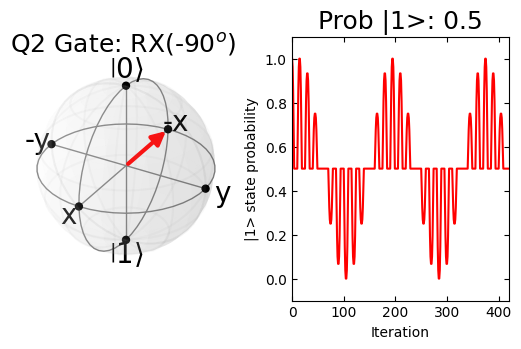

In [ ]:
#scaling to 1Q with xy plot  #20230928 - method

wfig = 8.6
fig = plt.figure(constrained_layout=True, figsize = (1.5*cm_to_inch(8.6),
                                                    1*cm_to_inch(8.6)))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, hspace =0.05,
                                 wspace=0.05)

ax0 = fig.add_subplot(spec[0, 0], projection='3d') #bloch sphere
ax1 = fig.add_subplot(spec[0, 1]) #probability of oscillation

#set initial config to bloch spheres with corresponding axes labels
#i.e. b0 = qutip.Bloch(axes=ax0), b1=qutip.Bloch(axes=ax1) ...
b0 = qutip.Bloch(axes=ax0)

# assuming state_arr is obtained from previous config file
# make a list of bloch spheres, list of animation lists and arrays of states per
# qubit
# we add color vector for distinction
bs_lst_1Q_plot = [b0]
arr_lst_1Q_plot = [state_arr]
arcs_lst_1Q_plot = [state_anim_list]
q_cols_1Q_plot= ['r']
zlabel_1Q_plot = [[r'$\left|0\right>$', r'$\left|1\right>$']]
glabel_1Q_plot = [gate_names] #simpler but requires non-automated axes

# set plot for initial qubit probability for 4 X gates
iter = np.linspace(0, len(state_arr) - 1, len(state_arr))
#scat = ax1.scatter(0, prob_1_state_arr[0], c="b", s=5) #plot scatter data
line = ax1.plot(0, prob_1_state_arr[0], 'r-')[0] #plot line data
ax1.set(xlim=[-1, len(iter)+1], ylim=[-0.1, 1.1], xlabel='Iteration', ylabel='|1> state probability')
ax1.tick_params(direction='in', right=True, top=True)

def initiate_bloch_qn_with_arc(bs, list_states=[], qcol='g', zlabel=[]):
    """
    Initialize plot of bloch sphere. Must be dedicated to only one sphere of
    interest. The good thing is that one can externally assign bloch spheres
    for modification.

    In the future, it would be nice to extend labeling Z-axes for information.

    Based on old script

    Parameters
    ----------
    bs : Bloch
      qutip bloch sphere
    list_states: list of Qobj
      state vectors giving hints for arc trajectory
    *kwargs: additional keynote arguments


    Returns
    -------
    None.

    """
    # Highlight nodes on diagram
    # |0>, -y, +x, +y
    # D:\Postgrad Projects\Qiskit_Textbook\bloch sphere plotting\qutip q2_sq cz_operate\Qutip q1=0.py
    xp = np.asarray([0, 0, 1, 0, 0, -1])
    yp = np.asarray([0, -1, 0, 1, 0, 0])
    zp = np.asarray([1, 0, 0, 0, -1, 0])
    pnts = [xp, yp, zp]
    bs.add_points(pnts)
    #bs.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
    #check for same states for arc

    #draw arc based on states
    if list_states == []:
      #no need for drawing arcs if no arcs are intended to be drawn
      #useful for
      pass
    else:
      list_coords = gate_arcs_all(list_states) #shows 3 points
      f = len(list_states)
      m = int((f-1)/2) #mid point
      if ((round(list_coords[0][0],6) == round(list_coords[-1][0],6))
      & (round(list_coords[0][1],6) == round(list_coords[-1][1],6))
      & (round(list_coords[0][-1],6) == round(list_coords[-1][-1],6))):
        # make a pass if a coordinate arr[0][x,y,z] and arr[-1][x,y,z] of an arc has the same point
        # round is added to remove rounding errors
        pass
      else:
        #draw all arcs #Optimal Hadamard Trajectories are hard from transpiler
        [bs.add_arc(start=list_coords[i], end=list_coords[i+1], fmt=qcol,
                          ls='dashed', lw=4) for i in range(f-1)]

    # Format Bloch Sphere first
    bs.vector_color = [qcol, qcol, qcol, qcol]
    bs.frame_alpha = 0.05
    bs.point_color = ['k', 'k', 'k', 'k', '#CC6600']
    bs.point_marker = ['o', 'o', 'o', 'o']
    bs.frame_num = 12
    bs.sphere_alpha = 0.1
    bs.xlabel = ['x', '-x']
    bs.ylabel = ['y', '-y']
    bs.sphere_color = 'white'
    if zlabel == []:
      bs.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
    else:
      bs.zlabel = zlabel

def b_plot(i, j, bs, b_states, b_state_arcs, qcol, zlabel):
  """
  methood to scale up bs config.
  scale b sphere according to number of bloch spheres
  i - frames in int
  j - number of batches of frames in int
  b_sphere - bloch number
  b_states - list of states evolved by i
  b_state_arcs - list of state_arcs evolved by j
  qcol - color of vectors
  zlabel - assignment of states
  """
  bs.clear()
  initiate_bloch_qn_with_arc(bs, b_state_arcs[j], qcol, zlabel)
  bs.add_states([b_states[i]])
  bs.show()

def animate_add_vec(i, bs_lst, arr_lst, arcs_lst, qcols, zlabels, gate_labels):
  """
  animate bloch sphere entertaining configs of bloch plots.
  for every bloch sphere, there returns a corresponding axes
  i = frames
  bs_list is the bloch spheres of concern
  arr_lst is a list of 1D states all qubit vector works,
  arcs_lst is a list of arcs used for qubit gates
  qcols are list of colors of each qubit states
  z-labels are lists of states needed for operation. Default is [[], []]
  """
  #assign j for number of points per movie

  pts = len(arcs_lst[0][0]) #pts per gate
  j = int(i/(pts))
  j_max = int(len(arr_lst[0])/pts)
  print(j)
  for m in range(len(bs_lst)):
    #m = 2 for this list
    b_plot(i, j, bs_lst[m], arr_lst[m], arcs_lst[m], qcols[m], zlabels[m])
  ax0.set_title('Q2 Gate: ' + gate_labels[0][j], fontsize=18)

  #set axes plot for |1> probability x vs y axis
  #example - https://matplotlib.org/stable/users/explain/animations/animations.html
  # had to insert label here
  ax1.set_title('Prob |1>: ' + str(round(prob_1_state_arr[i], 3)), fontsize=18)
  # for each frame, update the data stored on each artist.
  x = iter[:int(i+1)]
  y = prob_1_state_arr[:int(i+1)]
  # update the scatter plot:
  data = np.stack([x, y]).T
  #put argument to plot scatter plot or line
  plot = 'line'
  if plot != 'line':
    #give scatter plot
    scat.set_offsets(data) #scatter plot
  else:
    # update the line plot
    line.set_xdata(x)
    line.set_ydata(y)
  return ax0, ax1

def init(bs_lst, qcols, gate_labels):
    # b-sphare
    for m in range(len(bs_lst)):
      bs_lst[m].vector_color = [qcols[m]]
    return ax0, ax1

# inquiry with the working of the code
# does the init() function acts as precursor. Also, how do we scale the bloch
# sphere to 5Q and 9Q in sequence
# init bloch sphere states must be embedded in place.

#for scalabe lsts of states, update bs_list according to the list of operations
#and use partial
#https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html

ani = animation.FuncAnimation(fig, partial(animate_add_vec, bs_lst=bs_lst_1Q_plot,
 arr_lst=arr_lst_1Q_plot,
 arcs_lst=arcs_lst_1Q_plot,
 qcols=q_cols_1Q_plot,
                                           zlabels=zlabel_1Q_plot,
                                           gate_labels=glabel_1Q_plot),
                              np.arange(len(state_arr)),
                              init_func = partial(init, bs_lst_1Q_plot, q_cols_1Q_plot,
                                                  glabel_1Q_plot),
                              repeat=False)
fname = 'b_sphere_'+'1Q_' + purpose + '_' + test + '_plot.mp4' #with trajectory
ani.save(fname, fps=10)
#time = 4m 25s

# Task 3: Envelope of Rotation Gates (Hadamard)
This is in preparation for Hadamard gate rotation version in calibrating a CNOT operation. Here, the target qubit is being remeasured time to time.

In [ ]:
# configuration file includes gate sequences
#test = 'test_0' #|0>
test = 'test_1' #|1>
psi_test1 = dict_psi[test]
pts = 9 #must be odd
n = 21*4 #number of gate loops
#test for negative X rotation
gate_list = ['H' if ((i % 3==0) or (i%3== 2)) else 'RZ' for i in range(n)] #7 arcs

purpose = 'H-RZ(theta)-H'+str(int(pts))+'pts_'+str(int(n))+'g'
gate_angle = np.ones(n, dtype=int)
for i in range(n):
  if (i % 3)==0:
    gate_angle[i] *= 90
  elif (i % 3)==1:
    m = int(i/3)
    if m == 0:
      gate_angle[i] *= 0
    else:
      gate_angle[i] *= 30
  else:
    gate_angle[i] *= -90

#Add I gate
def user_gate_I():
     # Identity Gate
     mat = np.array([[1.,   0],
                     [0., 1.]])
     return Qobj(mat, dims=[[2], [2]])

#Plot circuits and get list of states
qc = QubitCircuit(N=1, num_cbits=1)
qc.user_gates = {"I": user_gate_I} #add I-gate

# add control line that applies the gates
qc.add_state(state='0', targets=[0], state_type='input') #qubit operated upon
qc.add_state(state='c0', targets=[1], state_type='input') #classical register for measurement and control

# Automate gate list. Is it necessary to put classical controls?
n = len(gate_list)

#use list comprehension for this work - works for 1Q
#classical controls are setups that helps control the gate or do not help control
#the gate. What CZ does not help is the analysis

#circuit drawing is dependent on the propagators of the circuit
[qc.add_gate(gate_list[i], targets=0, classical_controls=[0]) if gate_list[i][0] != 'R'
else qc.add_gate(gate_list[i], targets=0, classical_controls=[0],
                 arg_value=np.radians(gate_angle[i]),
                 arg_label=r'{:1d}^o'.format(gate_angle[i])) for i in range(n)]

# plot circuits
qc.draw(file_type='png', file_name='circuit_1Q_'+purpose)

#relabel gates for tracking in animation
gate_names = [gate_list[i] if (gate_list[i][0] != 'R')
              else (gate_list[i] + '(' + str(gate_angle[i]) + r'$^{o}$' + ')')
              for i in range(n)]

#use propagators - propagators work only for 1Q
props = qc.propagators()

# Advantages: no need for making a unitary matrix
#set final and initial state of access
gate_fin_arr = [psi_test1 for i in range(n)]
for i in range(n):
   if i == 0:
     gate_fin_arr[i] = Qobj(props[i]*gate_fin_arr[i])
   else:
     gate_fin_arr[i] = Qobj(props[i]*gate_fin_arr[i-1])
  #this can be made in list-comprehension for speed.
  #advantage

gate_start_arr = [psi_test1] + gate_fin_arr[:int(n-1)]

# for debug purposes
debug = 'N'
if debug == 'Y':
  #Get Initial State
  print('State after Operation:')
  print(gate_fin_arr)
  print('\n')
  #get initial state before gate operation for iterative generation of animation
  print('State before Operation')
  print(gate_start_arr)

/usr/local/lib/python3.10/dist-packages/qutip_qip/circuit/circuit_latex.py:95: UserWarning: Could not locate system 'pdfcrop': image output may have additional margins.
  warnings.warn(


In [ ]:
#make sequential animation to highlight trajectories
#We make a list of 1D lists of animated Qobj states for a single qubit
state_anim_list = [rot_R(init_list=[gate_start_arr[i], 0, gate_list[i]],
                         angle=gate_angle[i], pts=pts)[1] for i in range(n)]
print('\n')
print('Number of gates: {:1d}'.format(len(state_anim_list)))
print('Number of animation per gate : {:1d}'.format(len(state_anim_list[0])))

def flatten_comprehension(matrix):
  #Try flatten gates for drawing arcs per gate
  #https://realpython.com/python-flatten-list/
  return [item for row in matrix for item in row]

state_arr = flatten_comprehension(state_anim_list)
print('\n')
print('Number of animation per list : {:1d}'.format(len(state_arr)))
print('\n')

#get |1> probabilities
#practice getting probability of |1> state
prob_1_state_arr = np.array([extract_state_info_qt(state_arr[i])['prob'][1] for i in range(len(state_arr))])
print(prob_1_state_arr[2])

<ipython-input-5-3937fde6f9f3>:47: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  hadamard = hadamard_transform()




Number of gates: 84
Number of animation per gate : 9


Number of animation per list : 756


0.9267766952966368


0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

5


<Figure size 500x500 with 0 Axes>

5


<Figure size 500x500 with 0 Axes>

5


<Figure size 500x500 with 0 Axes>

5


<Figure size 500x500 with 0 Axes>

5


<Figure size 500x500 with 0 Axes>

5


<Figure size 500x500 with 0 Axes>

5


<Figure size 500x500 with 0 Axes>

5


<Figure size 500x500 with 0 Axes>

5


<Figure size 500x500 with 0 Axes>

6


<Figure size 500x500 with 0 Axes>

6


<Figure size 500x500 with 0 Axes>

6


<Figure size 500x500 with 0 Axes>

6


<Figure size 500x500 with 0 Axes>

6


<Figure size 500x500 with 0 Axes>

6


<Figure size 500x500 with 0 Axes>

6


<Figure size 500x500 with 0 Axes>

6


<Figure size 500x500 with 0 Axes>

6


<Figure size 500x500 with 0 Axes>

7


<Figure size 500x500 with 0 Axes>

7


<Figure size 500x500 with 0 Axes>

7


<Figure size 500x500 with 0 Axes>

7


<Figure size 500x500 with 0 Axes>

7


<Figure size 500x500 with 0 Axes>

7


<Figure size 500x500 with 0 Axes>

7


<Figure size 500x500 with 0 Axes>

7


<Figure size 500x500 with 0 Axes>

7


<Figure size 500x500 with 0 Axes>

8


<Figure size 500x500 with 0 Axes>

8


<Figure size 500x500 with 0 Axes>

8


<Figure size 500x500 with 0 Axes>

8


<Figure size 500x500 with 0 Axes>

8


<Figure size 500x500 with 0 Axes>

8


<Figure size 500x500 with 0 Axes>

8


<Figure size 500x500 with 0 Axes>

8


<Figure size 500x500 with 0 Axes>

8


<Figure size 500x500 with 0 Axes>

9


<Figure size 500x500 with 0 Axes>

9


<Figure size 500x500 with 0 Axes>

9


<Figure size 500x500 with 0 Axes>

9


<Figure size 500x500 with 0 Axes>

9


<Figure size 500x500 with 0 Axes>

9


<Figure size 500x500 with 0 Axes>

9


<Figure size 500x500 with 0 Axes>

9


<Figure size 500x500 with 0 Axes>

9


<Figure size 500x500 with 0 Axes>

10


<Figure size 500x500 with 0 Axes>

10


<Figure size 500x500 with 0 Axes>

10


<Figure size 500x500 with 0 Axes>

10


<Figure size 500x500 with 0 Axes>

10


<Figure size 500x500 with 0 Axes>

10


<Figure size 500x500 with 0 Axes>

10


<Figure size 500x500 with 0 Axes>

10


<Figure size 500x500 with 0 Axes>

10


<Figure size 500x500 with 0 Axes>

11


<Figure size 500x500 with 0 Axes>

11


<Figure size 500x500 with 0 Axes>

11


<Figure size 500x500 with 0 Axes>

11


<Figure size 500x500 with 0 Axes>

11


<Figure size 500x500 with 0 Axes>

11


<Figure size 500x500 with 0 Axes>

11


<Figure size 500x500 with 0 Axes>

11


<Figure size 500x500 with 0 Axes>

11


<Figure size 500x500 with 0 Axes>

12


<Figure size 500x500 with 0 Axes>

12


<Figure size 500x500 with 0 Axes>

12


<Figure size 500x500 with 0 Axes>

12


<Figure size 500x500 with 0 Axes>

12


<Figure size 500x500 with 0 Axes>

12


<Figure size 500x500 with 0 Axes>

12


<Figure size 500x500 with 0 Axes>

12


<Figure size 500x500 with 0 Axes>

12


<Figure size 500x500 with 0 Axes>

13


<Figure size 500x500 with 0 Axes>

13


<Figure size 500x500 with 0 Axes>

13


<Figure size 500x500 with 0 Axes>

13


<Figure size 500x500 with 0 Axes>

13


<Figure size 500x500 with 0 Axes>

13


<Figure size 500x500 with 0 Axes>

13


<Figure size 500x500 with 0 Axes>

13


<Figure size 500x500 with 0 Axes>

13


<Figure size 500x500 with 0 Axes>

14


<Figure size 500x500 with 0 Axes>

14


<Figure size 500x500 with 0 Axes>

14


<Figure size 500x500 with 0 Axes>

14


<Figure size 500x500 with 0 Axes>

14


<Figure size 500x500 with 0 Axes>

14


<Figure size 500x500 with 0 Axes>

14


<Figure size 500x500 with 0 Axes>

14


<Figure size 500x500 with 0 Axes>

14


<Figure size 500x500 with 0 Axes>

15


<Figure size 500x500 with 0 Axes>

15


<Figure size 500x500 with 0 Axes>

15


<Figure size 500x500 with 0 Axes>

15


<Figure size 500x500 with 0 Axes>

15


<Figure size 500x500 with 0 Axes>

15


<Figure size 500x500 with 0 Axes>

15


<Figure size 500x500 with 0 Axes>

15


<Figure size 500x500 with 0 Axes>

15


<Figure size 500x500 with 0 Axes>

16


<Figure size 500x500 with 0 Axes>

16


<Figure size 500x500 with 0 Axes>

16


<Figure size 500x500 with 0 Axes>

16


<Figure size 500x500 with 0 Axes>

16


<Figure size 500x500 with 0 Axes>

16


<Figure size 500x500 with 0 Axes>

16


<Figure size 500x500 with 0 Axes>

16


<Figure size 500x500 with 0 Axes>

16


<Figure size 500x500 with 0 Axes>

17


<Figure size 500x500 with 0 Axes>

17


<Figure size 500x500 with 0 Axes>

17


<Figure size 500x500 with 0 Axes>

17


<Figure size 500x500 with 0 Axes>

17


<Figure size 500x500 with 0 Axes>

17


<Figure size 500x500 with 0 Axes>

17


<Figure size 500x500 with 0 Axes>

17


<Figure size 500x500 with 0 Axes>

17


<Figure size 500x500 with 0 Axes>

18


<Figure size 500x500 with 0 Axes>

18


<Figure size 500x500 with 0 Axes>

18


<Figure size 500x500 with 0 Axes>

18


<Figure size 500x500 with 0 Axes>

18


<Figure size 500x500 with 0 Axes>

18


<Figure size 500x500 with 0 Axes>

18


<Figure size 500x500 with 0 Axes>

18


<Figure size 500x500 with 0 Axes>

18


<Figure size 500x500 with 0 Axes>

19


<Figure size 500x500 with 0 Axes>

19


<Figure size 500x500 with 0 Axes>

19


<Figure size 500x500 with 0 Axes>

19


<Figure size 500x500 with 0 Axes>

19


<Figure size 500x500 with 0 Axes>

19


<Figure size 500x500 with 0 Axes>

19


<Figure size 500x500 with 0 Axes>

19


<Figure size 500x500 with 0 Axes>

19


<Figure size 500x500 with 0 Axes>

20


<Figure size 500x500 with 0 Axes>

20


<Figure size 500x500 with 0 Axes>

20


<Figure size 500x500 with 0 Axes>

20


<Figure size 500x500 with 0 Axes>

20


<Figure size 500x500 with 0 Axes>

20


<Figure size 500x500 with 0 Axes>

20


<Figure size 500x500 with 0 Axes>

20


<Figure size 500x500 with 0 Axes>

20


<Figure size 500x500 with 0 Axes>

21


<Figure size 500x500 with 0 Axes>

21


<Figure size 500x500 with 0 Axes>

21


<Figure size 500x500 with 0 Axes>

21


<Figure size 500x500 with 0 Axes>

21


<Figure size 500x500 with 0 Axes>

21


<Figure size 500x500 with 0 Axes>

21


<Figure size 500x500 with 0 Axes>

21


<Figure size 500x500 with 0 Axes>

21


<Figure size 500x500 with 0 Axes>

22


<Figure size 500x500 with 0 Axes>

22


<Figure size 500x500 with 0 Axes>

22


<Figure size 500x500 with 0 Axes>

22


<Figure size 500x500 with 0 Axes>

22


<Figure size 500x500 with 0 Axes>

22


<Figure size 500x500 with 0 Axes>

22


<Figure size 500x500 with 0 Axes>

22


<Figure size 500x500 with 0 Axes>

22


<Figure size 500x500 with 0 Axes>

23


<Figure size 500x500 with 0 Axes>

23


<Figure size 500x500 with 0 Axes>

23


<Figure size 500x500 with 0 Axes>

23


<Figure size 500x500 with 0 Axes>

23


<Figure size 500x500 with 0 Axes>

23


<Figure size 500x500 with 0 Axes>

23


<Figure size 500x500 with 0 Axes>

23


<Figure size 500x500 with 0 Axes>

23


<Figure size 500x500 with 0 Axes>

24


<Figure size 500x500 with 0 Axes>

24


<Figure size 500x500 with 0 Axes>

24


<Figure size 500x500 with 0 Axes>

24


<Figure size 500x500 with 0 Axes>

24


<Figure size 500x500 with 0 Axes>

24


<Figure size 500x500 with 0 Axes>

24


<Figure size 500x500 with 0 Axes>

24


<Figure size 500x500 with 0 Axes>

24


<Figure size 500x500 with 0 Axes>

25


<Figure size 500x500 with 0 Axes>

25


<Figure size 500x500 with 0 Axes>

25


<Figure size 500x500 with 0 Axes>

25


<Figure size 500x500 with 0 Axes>

25


<Figure size 500x500 with 0 Axes>

25


<Figure size 500x500 with 0 Axes>

25


<Figure size 500x500 with 0 Axes>

25


<Figure size 500x500 with 0 Axes>

25


<Figure size 500x500 with 0 Axes>

26


<Figure size 500x500 with 0 Axes>

26


<Figure size 500x500 with 0 Axes>

26


<Figure size 500x500 with 0 Axes>

26


<Figure size 500x500 with 0 Axes>

26


<Figure size 500x500 with 0 Axes>

26


<Figure size 500x500 with 0 Axes>

26


<Figure size 500x500 with 0 Axes>

26


<Figure size 500x500 with 0 Axes>

26


<Figure size 500x500 with 0 Axes>

27


<Figure size 500x500 with 0 Axes>

27


<Figure size 500x500 with 0 Axes>

27


<Figure size 500x500 with 0 Axes>

27


<Figure size 500x500 with 0 Axes>

27


<Figure size 500x500 with 0 Axes>

27


<Figure size 500x500 with 0 Axes>

27


<Figure size 500x500 with 0 Axes>

27


<Figure size 500x500 with 0 Axes>

27


<Figure size 500x500 with 0 Axes>

28


<Figure size 500x500 with 0 Axes>

28


<Figure size 500x500 with 0 Axes>

28


<Figure size 500x500 with 0 Axes>

28


<Figure size 500x500 with 0 Axes>

28


<Figure size 500x500 with 0 Axes>

28


<Figure size 500x500 with 0 Axes>

28


<Figure size 500x500 with 0 Axes>

28


<Figure size 500x500 with 0 Axes>

28


<Figure size 500x500 with 0 Axes>

29


<Figure size 500x500 with 0 Axes>

29


<Figure size 500x500 with 0 Axes>

29


<Figure size 500x500 with 0 Axes>

29


<Figure size 500x500 with 0 Axes>

29


<Figure size 500x500 with 0 Axes>

29


<Figure size 500x500 with 0 Axes>

29


<Figure size 500x500 with 0 Axes>

29


<Figure size 500x500 with 0 Axes>

29


<Figure size 500x500 with 0 Axes>

30


<Figure size 500x500 with 0 Axes>

30


<Figure size 500x500 with 0 Axes>

30


<Figure size 500x500 with 0 Axes>

30


<Figure size 500x500 with 0 Axes>

30


<Figure size 500x500 with 0 Axes>

30


<Figure size 500x500 with 0 Axes>

30


<Figure size 500x500 with 0 Axes>

30


<Figure size 500x500 with 0 Axes>

30


<Figure size 500x500 with 0 Axes>

31


<Figure size 500x500 with 0 Axes>

31


<Figure size 500x500 with 0 Axes>

31


<Figure size 500x500 with 0 Axes>

31


<Figure size 500x500 with 0 Axes>

31


<Figure size 500x500 with 0 Axes>

31


<Figure size 500x500 with 0 Axes>

31


<Figure size 500x500 with 0 Axes>

31


<Figure size 500x500 with 0 Axes>

31


<Figure size 500x500 with 0 Axes>

32


<Figure size 500x500 with 0 Axes>

32


<Figure size 500x500 with 0 Axes>

32


<Figure size 500x500 with 0 Axes>

32


<Figure size 500x500 with 0 Axes>

32


<Figure size 500x500 with 0 Axes>

32


<Figure size 500x500 with 0 Axes>

32


<Figure size 500x500 with 0 Axes>

32


<Figure size 500x500 with 0 Axes>

32


<Figure size 500x500 with 0 Axes>

33


<Figure size 500x500 with 0 Axes>

33


<Figure size 500x500 with 0 Axes>

33


<Figure size 500x500 with 0 Axes>

33


<Figure size 500x500 with 0 Axes>

33


<Figure size 500x500 with 0 Axes>

33


<Figure size 500x500 with 0 Axes>

33


<Figure size 500x500 with 0 Axes>

33


<Figure size 500x500 with 0 Axes>

33


<Figure size 500x500 with 0 Axes>

34


<Figure size 500x500 with 0 Axes>

34


<Figure size 500x500 with 0 Axes>

34


<Figure size 500x500 with 0 Axes>

34


<Figure size 500x500 with 0 Axes>

34


<Figure size 500x500 with 0 Axes>

34


<Figure size 500x500 with 0 Axes>

34


<Figure size 500x500 with 0 Axes>

34


<Figure size 500x500 with 0 Axes>

34


<Figure size 500x500 with 0 Axes>

35


<Figure size 500x500 with 0 Axes>

35


<Figure size 500x500 with 0 Axes>

35


<Figure size 500x500 with 0 Axes>

35


<Figure size 500x500 with 0 Axes>

35


<Figure size 500x500 with 0 Axes>

35


<Figure size 500x500 with 0 Axes>

35


<Figure size 500x500 with 0 Axes>

35


<Figure size 500x500 with 0 Axes>

35


<Figure size 500x500 with 0 Axes>

36


<Figure size 500x500 with 0 Axes>

36


<Figure size 500x500 with 0 Axes>

36


<Figure size 500x500 with 0 Axes>

36


<Figure size 500x500 with 0 Axes>

36


<Figure size 500x500 with 0 Axes>

36


<Figure size 500x500 with 0 Axes>

36


<Figure size 500x500 with 0 Axes>

36


<Figure size 500x500 with 0 Axes>

36


<Figure size 500x500 with 0 Axes>

37


<Figure size 500x500 with 0 Axes>

37


<Figure size 500x500 with 0 Axes>

37


<Figure size 500x500 with 0 Axes>

37


<Figure size 500x500 with 0 Axes>

37


<Figure size 500x500 with 0 Axes>

37


<Figure size 500x500 with 0 Axes>

37


<Figure size 500x500 with 0 Axes>

37


<Figure size 500x500 with 0 Axes>

37


<Figure size 500x500 with 0 Axes>

38


<Figure size 500x500 with 0 Axes>

38


<Figure size 500x500 with 0 Axes>

38


<Figure size 500x500 with 0 Axes>

38


<Figure size 500x500 with 0 Axes>

38


<Figure size 500x500 with 0 Axes>

38


<Figure size 500x500 with 0 Axes>

38


<Figure size 500x500 with 0 Axes>

38


<Figure size 500x500 with 0 Axes>

38


<Figure size 500x500 with 0 Axes>

39


<Figure size 500x500 with 0 Axes>

39


<Figure size 500x500 with 0 Axes>

39


<Figure size 500x500 with 0 Axes>

39


<Figure size 500x500 with 0 Axes>

39


<Figure size 500x500 with 0 Axes>

39


<Figure size 500x500 with 0 Axes>

39


<Figure size 500x500 with 0 Axes>

39


<Figure size 500x500 with 0 Axes>

39


<Figure size 500x500 with 0 Axes>

40


<Figure size 500x500 with 0 Axes>

40


<Figure size 500x500 with 0 Axes>

40


<Figure size 500x500 with 0 Axes>

40


<Figure size 500x500 with 0 Axes>

40


<Figure size 500x500 with 0 Axes>

40


<Figure size 500x500 with 0 Axes>

40


<Figure size 500x500 with 0 Axes>

40


<Figure size 500x500 with 0 Axes>

40


<Figure size 500x500 with 0 Axes>

41


<Figure size 500x500 with 0 Axes>

41


<Figure size 500x500 with 0 Axes>

41


<Figure size 500x500 with 0 Axes>

41


<Figure size 500x500 with 0 Axes>

41


<Figure size 500x500 with 0 Axes>

41


<Figure size 500x500 with 0 Axes>

41


<Figure size 500x500 with 0 Axes>

41


<Figure size 500x500 with 0 Axes>

41


<Figure size 500x500 with 0 Axes>

42


<Figure size 500x500 with 0 Axes>

42


<Figure size 500x500 with 0 Axes>

42


<Figure size 500x500 with 0 Axes>

42


<Figure size 500x500 with 0 Axes>

42


<Figure size 500x500 with 0 Axes>

42


<Figure size 500x500 with 0 Axes>

42


<Figure size 500x500 with 0 Axes>

42


<Figure size 500x500 with 0 Axes>

42


<Figure size 500x500 with 0 Axes>

43


<Figure size 500x500 with 0 Axes>

43


<Figure size 500x500 with 0 Axes>

43


<Figure size 500x500 with 0 Axes>

43


<Figure size 500x500 with 0 Axes>

43


<Figure size 500x500 with 0 Axes>

43


<Figure size 500x500 with 0 Axes>

43


<Figure size 500x500 with 0 Axes>

43


<Figure size 500x500 with 0 Axes>

43


<Figure size 500x500 with 0 Axes>

44


<Figure size 500x500 with 0 Axes>

44


<Figure size 500x500 with 0 Axes>

44


<Figure size 500x500 with 0 Axes>

44


<Figure size 500x500 with 0 Axes>

44


<Figure size 500x500 with 0 Axes>

44


<Figure size 500x500 with 0 Axes>

44


<Figure size 500x500 with 0 Axes>

44


<Figure size 500x500 with 0 Axes>

44


<Figure size 500x500 with 0 Axes>

45


<Figure size 500x500 with 0 Axes>

45


<Figure size 500x500 with 0 Axes>

45


<Figure size 500x500 with 0 Axes>

45


<Figure size 500x500 with 0 Axes>

45


<Figure size 500x500 with 0 Axes>

45


<Figure size 500x500 with 0 Axes>

45


<Figure size 500x500 with 0 Axes>

45


<Figure size 500x500 with 0 Axes>

45


<Figure size 500x500 with 0 Axes>

46


<Figure size 500x500 with 0 Axes>

46


<Figure size 500x500 with 0 Axes>

46


<Figure size 500x500 with 0 Axes>

46


<Figure size 500x500 with 0 Axes>

46


<Figure size 500x500 with 0 Axes>

46


<Figure size 500x500 with 0 Axes>

46


<Figure size 500x500 with 0 Axes>

46


<Figure size 500x500 with 0 Axes>

46


<Figure size 500x500 with 0 Axes>

47


<Figure size 500x500 with 0 Axes>

47


<Figure size 500x500 with 0 Axes>

47


<Figure size 500x500 with 0 Axes>

47


<Figure size 500x500 with 0 Axes>

47


<Figure size 500x500 with 0 Axes>

47


<Figure size 500x500 with 0 Axes>

47


<Figure size 500x500 with 0 Axes>

47


<Figure size 500x500 with 0 Axes>

47


<Figure size 500x500 with 0 Axes>

48


<Figure size 500x500 with 0 Axes>

48


<Figure size 500x500 with 0 Axes>

48


<Figure size 500x500 with 0 Axes>

48


<Figure size 500x500 with 0 Axes>

48


<Figure size 500x500 with 0 Axes>

48


<Figure size 500x500 with 0 Axes>

48


<Figure size 500x500 with 0 Axes>

48


<Figure size 500x500 with 0 Axes>

48


<Figure size 500x500 with 0 Axes>

49


<Figure size 500x500 with 0 Axes>

49


<Figure size 500x500 with 0 Axes>

49


<Figure size 500x500 with 0 Axes>

49


<Figure size 500x500 with 0 Axes>

49


<Figure size 500x500 with 0 Axes>

49


<Figure size 500x500 with 0 Axes>

49


<Figure size 500x500 with 0 Axes>

49


<Figure size 500x500 with 0 Axes>

49


<Figure size 500x500 with 0 Axes>

50


<Figure size 500x500 with 0 Axes>

50


<Figure size 500x500 with 0 Axes>

50


<Figure size 500x500 with 0 Axes>

50


<Figure size 500x500 with 0 Axes>

50


<Figure size 500x500 with 0 Axes>

50


<Figure size 500x500 with 0 Axes>

50


<Figure size 500x500 with 0 Axes>

50


<Figure size 500x500 with 0 Axes>

50


<Figure size 500x500 with 0 Axes>

51


<Figure size 500x500 with 0 Axes>

51


<Figure size 500x500 with 0 Axes>

51


<Figure size 500x500 with 0 Axes>

51


<Figure size 500x500 with 0 Axes>

51


<Figure size 500x500 with 0 Axes>

51


<Figure size 500x500 with 0 Axes>

51


<Figure size 500x500 with 0 Axes>

51


<Figure size 500x500 with 0 Axes>

51


<Figure size 500x500 with 0 Axes>

52


<Figure size 500x500 with 0 Axes>

52


<Figure size 500x500 with 0 Axes>

52


<Figure size 500x500 with 0 Axes>

52


<Figure size 500x500 with 0 Axes>

52


<Figure size 500x500 with 0 Axes>

52


<Figure size 500x500 with 0 Axes>

52


<Figure size 500x500 with 0 Axes>

52


<Figure size 500x500 with 0 Axes>

52


<Figure size 500x500 with 0 Axes>

53


<Figure size 500x500 with 0 Axes>

53


<Figure size 500x500 with 0 Axes>

53


<Figure size 500x500 with 0 Axes>

53


<Figure size 500x500 with 0 Axes>

53


<Figure size 500x500 with 0 Axes>

53


<Figure size 500x500 with 0 Axes>

53


<Figure size 500x500 with 0 Axes>

53


<Figure size 500x500 with 0 Axes>

53


<Figure size 500x500 with 0 Axes>

54


<Figure size 500x500 with 0 Axes>

54


<Figure size 500x500 with 0 Axes>

54


<Figure size 500x500 with 0 Axes>

54


<Figure size 500x500 with 0 Axes>

54


<Figure size 500x500 with 0 Axes>

54


<Figure size 500x500 with 0 Axes>

54


<Figure size 500x500 with 0 Axes>

54


<Figure size 500x500 with 0 Axes>

54


<Figure size 500x500 with 0 Axes>

55


<Figure size 500x500 with 0 Axes>

55


<Figure size 500x500 with 0 Axes>

55


<Figure size 500x500 with 0 Axes>

55


<Figure size 500x500 with 0 Axes>

55


<Figure size 500x500 with 0 Axes>

55


<Figure size 500x500 with 0 Axes>

55


<Figure size 500x500 with 0 Axes>

55


<Figure size 500x500 with 0 Axes>

55


<Figure size 500x500 with 0 Axes>

56


<Figure size 500x500 with 0 Axes>

56


<Figure size 500x500 with 0 Axes>

56


<Figure size 500x500 with 0 Axes>

56


<Figure size 500x500 with 0 Axes>

56


<Figure size 500x500 with 0 Axes>

56


<Figure size 500x500 with 0 Axes>

56


<Figure size 500x500 with 0 Axes>

56


<Figure size 500x500 with 0 Axes>

56


<Figure size 500x500 with 0 Axes>

57


<Figure size 500x500 with 0 Axes>

57


<Figure size 500x500 with 0 Axes>

57


<Figure size 500x500 with 0 Axes>

57


<Figure size 500x500 with 0 Axes>

57


<Figure size 500x500 with 0 Axes>

57


<Figure size 500x500 with 0 Axes>

57


<Figure size 500x500 with 0 Axes>

57


<Figure size 500x500 with 0 Axes>

57


<Figure size 500x500 with 0 Axes>

58


<Figure size 500x500 with 0 Axes>

58


<Figure size 500x500 with 0 Axes>

58


<Figure size 500x500 with 0 Axes>

58


<Figure size 500x500 with 0 Axes>

58


<Figure size 500x500 with 0 Axes>

58


<Figure size 500x500 with 0 Axes>

58


<Figure size 500x500 with 0 Axes>

58


<Figure size 500x500 with 0 Axes>

58


<Figure size 500x500 with 0 Axes>

59


<Figure size 500x500 with 0 Axes>

59


<Figure size 500x500 with 0 Axes>

59


<Figure size 500x500 with 0 Axes>

59


<Figure size 500x500 with 0 Axes>

59


<Figure size 500x500 with 0 Axes>

59


<Figure size 500x500 with 0 Axes>

59


<Figure size 500x500 with 0 Axes>

59


<Figure size 500x500 with 0 Axes>

59


<Figure size 500x500 with 0 Axes>

60


<Figure size 500x500 with 0 Axes>

60


<Figure size 500x500 with 0 Axes>

60


<Figure size 500x500 with 0 Axes>

60


<Figure size 500x500 with 0 Axes>

60


<Figure size 500x500 with 0 Axes>

60


<Figure size 500x500 with 0 Axes>

60


<Figure size 500x500 with 0 Axes>

60


<Figure size 500x500 with 0 Axes>

60


<Figure size 500x500 with 0 Axes>

61


<Figure size 500x500 with 0 Axes>

61


<Figure size 500x500 with 0 Axes>

61


<Figure size 500x500 with 0 Axes>

61


<Figure size 500x500 with 0 Axes>

61


<Figure size 500x500 with 0 Axes>

61


<Figure size 500x500 with 0 Axes>

61


<Figure size 500x500 with 0 Axes>

61


<Figure size 500x500 with 0 Axes>

61


<Figure size 500x500 with 0 Axes>

62


<Figure size 500x500 with 0 Axes>

62


<Figure size 500x500 with 0 Axes>

62


<Figure size 500x500 with 0 Axes>

62


<Figure size 500x500 with 0 Axes>

62


<Figure size 500x500 with 0 Axes>

62


<Figure size 500x500 with 0 Axes>

62


<Figure size 500x500 with 0 Axes>

62


<Figure size 500x500 with 0 Axes>

62


<Figure size 500x500 with 0 Axes>

63


<Figure size 500x500 with 0 Axes>

63


<Figure size 500x500 with 0 Axes>

63


<Figure size 500x500 with 0 Axes>

63


<Figure size 500x500 with 0 Axes>

63


<Figure size 500x500 with 0 Axes>

63


<Figure size 500x500 with 0 Axes>

63


<Figure size 500x500 with 0 Axes>

63


<Figure size 500x500 with 0 Axes>

63


<Figure size 500x500 with 0 Axes>

64


<Figure size 500x500 with 0 Axes>

64


<Figure size 500x500 with 0 Axes>

64


<Figure size 500x500 with 0 Axes>

64


<Figure size 500x500 with 0 Axes>

64


<Figure size 500x500 with 0 Axes>

64


<Figure size 500x500 with 0 Axes>

64


<Figure size 500x500 with 0 Axes>

64


<Figure size 500x500 with 0 Axes>

64


<Figure size 500x500 with 0 Axes>

65


<Figure size 500x500 with 0 Axes>

65


<Figure size 500x500 with 0 Axes>

65


<Figure size 500x500 with 0 Axes>

65


<Figure size 500x500 with 0 Axes>

65


<Figure size 500x500 with 0 Axes>

65


<Figure size 500x500 with 0 Axes>

65


<Figure size 500x500 with 0 Axes>

65


<Figure size 500x500 with 0 Axes>

65


<Figure size 500x500 with 0 Axes>

66


<Figure size 500x500 with 0 Axes>

66


<Figure size 500x500 with 0 Axes>

66


<Figure size 500x500 with 0 Axes>

66


<Figure size 500x500 with 0 Axes>

66


<Figure size 500x500 with 0 Axes>

66


<Figure size 500x500 with 0 Axes>

66


<Figure size 500x500 with 0 Axes>

66


<Figure size 500x500 with 0 Axes>

66


<Figure size 500x500 with 0 Axes>

67


<Figure size 500x500 with 0 Axes>

67


<Figure size 500x500 with 0 Axes>

67


<Figure size 500x500 with 0 Axes>

67


<Figure size 500x500 with 0 Axes>

67


<Figure size 500x500 with 0 Axes>

67


<Figure size 500x500 with 0 Axes>

67


<Figure size 500x500 with 0 Axes>

67


<Figure size 500x500 with 0 Axes>

67


<Figure size 500x500 with 0 Axes>

68


<Figure size 500x500 with 0 Axes>

68


<Figure size 500x500 with 0 Axes>

68


<Figure size 500x500 with 0 Axes>

68


<Figure size 500x500 with 0 Axes>

68


<Figure size 500x500 with 0 Axes>

68


<Figure size 500x500 with 0 Axes>

68


<Figure size 500x500 with 0 Axes>

68


<Figure size 500x500 with 0 Axes>

68


<Figure size 500x500 with 0 Axes>

69


<Figure size 500x500 with 0 Axes>

69


<Figure size 500x500 with 0 Axes>

69


<Figure size 500x500 with 0 Axes>

69


<Figure size 500x500 with 0 Axes>

69


<Figure size 500x500 with 0 Axes>

69


<Figure size 500x500 with 0 Axes>

69


<Figure size 500x500 with 0 Axes>

69


<Figure size 500x500 with 0 Axes>

69


<Figure size 500x500 with 0 Axes>

70


<Figure size 500x500 with 0 Axes>

70


<Figure size 500x500 with 0 Axes>

70


<Figure size 500x500 with 0 Axes>

70


<Figure size 500x500 with 0 Axes>

70


<Figure size 500x500 with 0 Axes>

70


<Figure size 500x500 with 0 Axes>

70


<Figure size 500x500 with 0 Axes>

70


<Figure size 500x500 with 0 Axes>

70


<Figure size 500x500 with 0 Axes>

71


<Figure size 500x500 with 0 Axes>

71


<Figure size 500x500 with 0 Axes>

71


<Figure size 500x500 with 0 Axes>

71


<Figure size 500x500 with 0 Axes>

71


<Figure size 500x500 with 0 Axes>

71


<Figure size 500x500 with 0 Axes>

71


<Figure size 500x500 with 0 Axes>

71


<Figure size 500x500 with 0 Axes>

71


<Figure size 500x500 with 0 Axes>

72


<Figure size 500x500 with 0 Axes>

72


<Figure size 500x500 with 0 Axes>

72


<Figure size 500x500 with 0 Axes>

72


<Figure size 500x500 with 0 Axes>

72


<Figure size 500x500 with 0 Axes>

72


<Figure size 500x500 with 0 Axes>

72


<Figure size 500x500 with 0 Axes>

72


<Figure size 500x500 with 0 Axes>

72


<Figure size 500x500 with 0 Axes>

73


<Figure size 500x500 with 0 Axes>

73


<Figure size 500x500 with 0 Axes>

73


<Figure size 500x500 with 0 Axes>

73


<Figure size 500x500 with 0 Axes>

73


<Figure size 500x500 with 0 Axes>

73


<Figure size 500x500 with 0 Axes>

73


<Figure size 500x500 with 0 Axes>

73


<Figure size 500x500 with 0 Axes>

73


<Figure size 500x500 with 0 Axes>

74


<Figure size 500x500 with 0 Axes>

74


<Figure size 500x500 with 0 Axes>

74


<Figure size 500x500 with 0 Axes>

74


<Figure size 500x500 with 0 Axes>

74


<Figure size 500x500 with 0 Axes>

74


<Figure size 500x500 with 0 Axes>

74


<Figure size 500x500 with 0 Axes>

74


<Figure size 500x500 with 0 Axes>

74


<Figure size 500x500 with 0 Axes>

75


<Figure size 500x500 with 0 Axes>

75


<Figure size 500x500 with 0 Axes>

75


<Figure size 500x500 with 0 Axes>

75


<Figure size 500x500 with 0 Axes>

75


<Figure size 500x500 with 0 Axes>

75


<Figure size 500x500 with 0 Axes>

75


<Figure size 500x500 with 0 Axes>

75


<Figure size 500x500 with 0 Axes>

75


<Figure size 500x500 with 0 Axes>

76


<Figure size 500x500 with 0 Axes>

76


<Figure size 500x500 with 0 Axes>

76


<Figure size 500x500 with 0 Axes>

76


<Figure size 500x500 with 0 Axes>

76


<Figure size 500x500 with 0 Axes>

76


<Figure size 500x500 with 0 Axes>

76


<Figure size 500x500 with 0 Axes>

76


<Figure size 500x500 with 0 Axes>

76


<Figure size 500x500 with 0 Axes>

77


<Figure size 500x500 with 0 Axes>

77


<Figure size 500x500 with 0 Axes>

77


<Figure size 500x500 with 0 Axes>

77


<Figure size 500x500 with 0 Axes>

77


<Figure size 500x500 with 0 Axes>

77


<Figure size 500x500 with 0 Axes>

77


<Figure size 500x500 with 0 Axes>

77


<Figure size 500x500 with 0 Axes>

77


<Figure size 500x500 with 0 Axes>

78


<Figure size 500x500 with 0 Axes>

78


<Figure size 500x500 with 0 Axes>

78


<Figure size 500x500 with 0 Axes>

78


<Figure size 500x500 with 0 Axes>

78


<Figure size 500x500 with 0 Axes>

78


<Figure size 500x500 with 0 Axes>

78


<Figure size 500x500 with 0 Axes>

78


<Figure size 500x500 with 0 Axes>

78


<Figure size 500x500 with 0 Axes>

79


<Figure size 500x500 with 0 Axes>

79


<Figure size 500x500 with 0 Axes>

79


<Figure size 500x500 with 0 Axes>

79


<Figure size 500x500 with 0 Axes>

79


<Figure size 500x500 with 0 Axes>

79


<Figure size 500x500 with 0 Axes>

79


<Figure size 500x500 with 0 Axes>

79


<Figure size 500x500 with 0 Axes>

79


<Figure size 500x500 with 0 Axes>

80


<Figure size 500x500 with 0 Axes>

80


<Figure size 500x500 with 0 Axes>

80


<Figure size 500x500 with 0 Axes>

80


<Figure size 500x500 with 0 Axes>

80


<Figure size 500x500 with 0 Axes>

80


<Figure size 500x500 with 0 Axes>

80


<Figure size 500x500 with 0 Axes>

80


<Figure size 500x500 with 0 Axes>

80


<Figure size 500x500 with 0 Axes>

81


<Figure size 500x500 with 0 Axes>

81


<Figure size 500x500 with 0 Axes>

81


<Figure size 500x500 with 0 Axes>

81


<Figure size 500x500 with 0 Axes>

81


<Figure size 500x500 with 0 Axes>

81


<Figure size 500x500 with 0 Axes>

81


<Figure size 500x500 with 0 Axes>

81


<Figure size 500x500 with 0 Axes>

81


<Figure size 500x500 with 0 Axes>

82


<Figure size 500x500 with 0 Axes>

82


<Figure size 500x500 with 0 Axes>

82


<Figure size 500x500 with 0 Axes>

82


<Figure size 500x500 with 0 Axes>

82


<Figure size 500x500 with 0 Axes>

82


<Figure size 500x500 with 0 Axes>

82


<Figure size 500x500 with 0 Axes>

82


<Figure size 500x500 with 0 Axes>

82


<Figure size 500x500 with 0 Axes>

83


<Figure size 500x500 with 0 Axes>

83


<Figure size 500x500 with 0 Axes>

83


<Figure size 500x500 with 0 Axes>

83


<Figure size 500x500 with 0 Axes>

83


<Figure size 500x500 with 0 Axes>

83


<Figure size 500x500 with 0 Axes>

83


<Figure size 500x500 with 0 Axes>

83


<Figure size 500x500 with 0 Axes>

83


<Figure size 500x500 with 0 Axes>

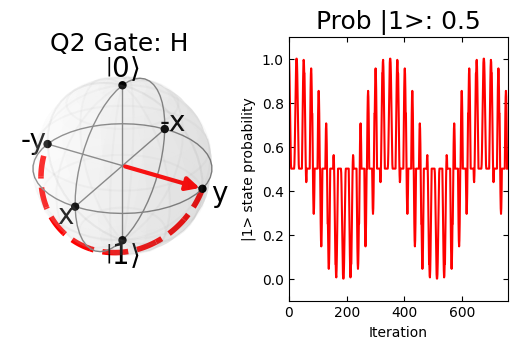

In [ ]:
#scaling to 1Q with xy plot  #20230928 - method

wfig = 8.6
fig = plt.figure(constrained_layout=True, figsize = (1.5*cm_to_inch(8.6),
                                                    1*cm_to_inch(8.6)))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, hspace =0.05,
                                 wspace=0.05)

ax0 = fig.add_subplot(spec[0, 0], projection='3d') #bloch sphere
ax1 = fig.add_subplot(spec[0, 1]) #probability of oscillation

#set initial config to bloch spheres with corresponding axes labels
#i.e. b0 = qutip.Bloch(axes=ax0), b1=qutip.Bloch(axes=ax1) ...
b0 = qutip.Bloch(axes=ax0)

# assuming state_arr is obtained from previous config file
# make a list of bloch spheres, list of animation lists and arrays of states per
# qubit
# we add color vector for distinction
bs_lst_1Q_plot = [b0]
arr_lst_1Q_plot = [state_arr]
arcs_lst_1Q_plot = [state_anim_list]
q_cols_1Q_plot= ['r']
zlabel_1Q_plot = [[r'$\left|0\right>$', r'$\left|1\right>$']]
glabel_1Q_plot = [gate_names] #simpler but requires non-automated axes

# set plot for initial qubit probability for 4 X gates
iter = np.linspace(0, len(state_arr) - 1, len(state_arr))
#scat = ax1.scatter(0, prob_1_state_arr[0], c="r", s=5) #plot scatter data
line = ax1.plot(0, prob_1_state_arr[0], 'r-')[0] #plot line data
ax1.set(xlim=[-1, len(iter)+1], ylim=[-0.1, 1.1], xlabel='Iteration', ylabel='|1> state probability')
ax1.tick_params(direction='in', right=True, top=True)

def initiate_bloch_qn_with_arc(bs, list_states=[], qcol='g', zlabel=[]):
    """
    Initialize plot of bloch sphere. Must be dedicated to only one sphere of
    interest. The good thing is that one can externally assign bloch spheres
    for modification.

    In the future, it would be nice to extend labeling Z-axes for information.

    Based on old script

    Parameters
    ----------
    bs : Bloch
      qutip bloch sphere
    list_states: list of Qobj
      state vectors giving hints for arc trajectory
    *kwargs: additional keynote arguments


    Returns
    -------
    None.

    """
    # Highlight nodes on diagram
    # |0>, -y, +x, +y
    # D:\Postgrad Projects\Qiskit_Textbook\bloch sphere plotting\qutip q2_sq cz_operate\Qutip q1=0.py
    xp = np.asarray([0, 0, 1, 0, 0, -1])
    yp = np.asarray([0, -1, 0, 1, 0, 0])
    zp = np.asarray([1, 0, 0, 0, -1, 0])
    pnts = [xp, yp, zp]
    bs.add_points(pnts)
    #bs.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
    #check for same states for arc

    #draw arc based on states
    if list_states == []:
      #no need for drawing arcs if no arcs are intended to be drawn
      #useful for
      pass
    else:
      list_coords = gate_arcs_all(list_states) #shows 3 points
      f = len(list_states)
      m = int((f-1)/2) #mid point
      if ((round(list_coords[0][0],6) == round(list_coords[-1][0],6))
      & (round(list_coords[0][1],6) == round(list_coords[-1][1],6))
      & (round(list_coords[0][-1],6) == round(list_coords[-1][-1],6))):
        # make a pass if a coordinate arr[0][x,y,z] and arr[-1][x,y,z] of an arc has the same point
        # round is added to remove rounding errors
        pass
      else:
        #draw all arcs #Optimal Hadamard Trajectories are hard from transpiler
        [bs.add_arc(start=list_coords[i], end=list_coords[i+1], fmt=qcol,
                          ls='dashed', lw=4) for i in range(f-1)]

    # Format Bloch Sphere first
    bs.vector_color = [qcol, qcol, qcol, qcol]
    bs.frame_alpha = 0.05
    bs.point_color = ['k', 'k', 'k', 'k', '#CC6600']
    bs.point_marker = ['o', 'o', 'o', 'o']
    bs.frame_num = 12
    bs.sphere_alpha = 0.1
    bs.xlabel = ['x', '-x']
    bs.ylabel = ['y', '-y']
    bs.sphere_color = 'white'
    if zlabel == []:
      bs.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
      # in the future, for joint states, one can write dates.
    else:
      bs.zlabel = zlabel

def b_plot(i, j, bs, b_states, b_state_arcs, qcol, zlabel):
  """
  methood to scale up bs config.
  scale b sphere according to number of bloch spheres
  i - frames in int
  j - number of batches of frames in int
  b_sphere - bloch number
  b_states - list of states evolved by i
  b_state_arcs - list of state_arcs evolved by j
  qcol - color of vectors
  zlabel - assignment of states
  """
  bs.clear()
  initiate_bloch_qn_with_arc(bs, b_state_arcs[j], qcol, zlabel)
  bs.add_states([b_states[i]])
  bs.show()

def animate_add_vec(i, bs_lst, arr_lst, arcs_lst, qcols, zlabels, gate_labels):
  """
  animate bloch sphere entertaining configs of bloch plots.
  for every bloch sphere, there returns a corresponding axes
  i = frames
  bs_list is the bloch spheres of concern
  arr_lst is a list of 1D states all qubit vector works,
  arcs_lst is a list of arcs used for qubit gates
  qcols are list of colors of each qubit states
  z-labels are lists of states needed for operation. Default is [[], []]
  """
  #assign j for number of points per movie

  pts = len(arcs_lst[0][0]) #pts per gate
  j = int(i/(pts))
  j_max = int(len(arr_lst[0])/pts)
  print(j)
  for m in range(len(bs_lst)):
    #m = 2 for this list
    b_plot(i, j, bs_lst[m], arr_lst[m], arcs_lst[m], qcols[m], zlabels[m])
  ax0.set_title('Q2 Gate: ' + gate_labels[0][j], fontsize=18)

  #set axes plot for |1> probability x vs y axis
  #example - https://matplotlib.org/stable/users/explain/animations/animations.html
  # had to insert label here
  ax1.set_title('Prob |1>: ' + str(round(prob_1_state_arr[i], 3)), fontsize=18)
  # for each frame, update the data stored on each artist.
  x = iter[:int(i+1)]
  y = prob_1_state_arr[:int(i+1)]
  # update the scatter plot:
  data = np.stack([x, y]).T
  #put argument to plot scatter plot or line
  plot = 'line'
  if plot != 'line':
    #give scatter plot
    scat.set_offsets(data) #scatter plot
  else:
    # update the line plot
    line.set_xdata(x)
    line.set_ydata(y)
  return ax0, ax1

def init(bs_lst, qcols, gate_labels):
    # b-sphare
    for m in range(len(bs_lst)):
      bs_lst[m].vector_color = [qcols[m]]
    return ax0, ax1

# inquiry with the working of the code
# does the init() function acts as precursor. Also, how do we scale the bloch
# sphere to 5Q and 9Q in sequence
# init bloch sphere states must be embedded in place.

#for scalabe lsts of states, update bs_list according to the list of operations
#and use partial
#https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html

ani = animation.FuncAnimation(fig, partial(animate_add_vec, bs_lst=bs_lst_1Q_plot,
 arr_lst=arr_lst_1Q_plot,
 arcs_lst=arcs_lst_1Q_plot,
 qcols=q_cols_1Q_plot,
                                           zlabels=zlabel_1Q_plot,
                                           gate_labels=glabel_1Q_plot),
                              np.arange(len(state_arr)),
                              init_func = partial(init, bs_lst_1Q_plot, q_cols_1Q_plot,
                                                  glabel_1Q_plot),
                              repeat=False)
fname = 'b_sphere_'+'1Q_' + purpose + '_' + test + '_plot.mp4' #with trajectory
ani.save(fname, fps=10)
#Runtime: 8m 8s

In [ ]:
from qutip.ipynbtools import version_table
version_table() #this is good

Software,Version
QuTiP,4.7.3
Numpy,1.23.5
SciPy,1.11.3
matplotlib,3.7.1
Cython,3.0.3
Number of CPUs,2
BLAS Info,OPENBLAS
IPython,7.34.0
Python,"3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]"
OS,posix [linux]


## Disclaimer
The bloch sphere oscillation has an extra oscillation between gates because for every gate animation, the end state of the preceeding gate and the start state of the next gate are duplicated. Otherwise, the plots faithfully reproduces what we expect from the bloch sphere animation.

## Key References:
1. Kwon, S., Tomonaga, A., Lakshmi Bhai, G., Devitt, S. J., & Tsai, J.-S. (2021). Gate-based superconducting quantum computing. Journal of Applied Physics, 129(4), 041102. doi:10.1063/5.0029735

2. Krantz, P., Kjaergaard, M., Yan, F., Orlando, T. P., Gustavsson, S., & Oliver, W. D. (2019). A quantum engineer's guide to superconducting qubits. Applied Physics Reviews, 6(2), 021318. doi:10.1063/1.5089550